In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import create_animation, imshow, default_rcParams
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [3]:
directory = "/scratch/pp2681/mom6/Apr2023/R4-sensitivity"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [4]:
directory = "/scratch/pp2681/mom6/Apr2023/R4-change-range"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name+'-range')

In [5]:
directory = "/scratch/pp2681/mom6/Apr2023/R4-selected"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [6]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/generalization', additional_subfolder='output')

Error, cannot find files in folder/scratch/pp2681/mom6/Apr2022/generalization/R2_EXP205-repeat/output
Error, cannot find files in folder/scratch/pp2681/mom6/Apr2022/generalization/R4_ZB-repeat/output


In [7]:
len(ds.exps)

2320

In [8]:
ds.remesh('R64', 'R4')

Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4


# Define error fucntions to be used for sensitivity plots

In [9]:
def error_ssh(exp):
    return Lk_error(ds[exp].ssh_mean,ds['R64_R4'].ssh_mean)[0]

In [10]:
def error_ssh_std(exp):
    return Lk_error(ds[exp].ssh_std,ds['R64_R4'].ssh_std)[0]

In [11]:
def error_spectrum(exp):
    return Lk_error(ds[exp].EKE_spectrum, ds['R64_R4'].EKE_spectrum)[0]

In [12]:
def error_spectrum_large(exp):
    return Lk_error(ds[exp].EKE_spectrum[:,0:3], ds['R64_R4'].EKE_spectrum[:,0:3])[0]

In [13]:
def error_energy(exp):
    return sum(ds[exp].Lk_error(ds['R64_R4'], features=['EKE_joul', 'MKE_joul'], normalize=False)[0]) * 1e-15

In [14]:
def error_total_energy(exp):
    return sum(ds[exp].Lk_error(ds['R64_R4'], features=['EKE_joul', 'MKE_joul', 'EPE_joul', 'MPE_joul', 'EPE_ssh', 'MPE_ssh'], normalize=False)[0]) * 1e-15

# Plotter for 2D sensitivity

In [15]:
def error_2d(error_function = error_ssh, prefix='ZB-clean'):
    if f'{prefix}-Cs-{0.03}-ZB-{7.0}' in ds.exps:
        ZBs = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0]
    elif f'{prefix}-Cs-{0.03}-ZB-{28.0}' in ds.exps:
        ZBs = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]
    elif f'{prefix}-Cs-{0.03}-ZB-{4.4}' in ds.exps:
        ZBs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0]
    elif f'{prefix}-Cs-{0.03}-ZB-{2.4}' in ds.exps:
        ZBs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]
    else:
        ZBs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
    error = np.zeros((len(ZBs), 3))
    for i, Cs in enumerate([0.03,0.06,0.09]):
        for j, ZB in enumerate(ZBs):
            try:
                error[j,i] = error_function(f'{prefix}-Cs-{Cs}-ZB-{ZB}')
            except:
                error[j,i] = 1e+10
    error = xr.DataArray(error, dims=['ZB', 'Cs'], coords={'Cs': [0.03,0.06,0.09], 'ZB': ZBs})
    return error

In [16]:
ssh = {'v0': 0.26709399, 'vmin': 0.0, 'error_function': error_ssh, 
       'color': 'w', 'cbar_ticks': np.arange(0.0,0.7,0.05), 
       'cbar_extend': 'neither', 'cbar_label': 'RMSE in \ntime-mean SSH, $m$'};
ssh_std = {'v0': 0.086690746, 'vmin': 0.0, 'error_function': error_ssh_std, 
           'color': 'k', 'cbar_ticks': np.arange(0,0.2,0.02), 
           'cbar_extend': 'max', 'cbar_label': 'RMSE in \nstandard deviation of SSH, $m$'};
sp = {'v0': 64.31411662832397, 'vmin': 0.0, 'error_function': error_spectrum, 
       'color': 'w', 'cbar_ticks': np.arange(0,140,10), 
       'cbar_extend': 'neither', 'cbar_label': 'RMSE in \nEKE spectrum, $m^3/s^2$'};

sp_large = {'v0': 99.26127116294647, 'vmin': 0.0, 'error_function': error_spectrum_large, 
       'color': 'w', 'cbar_ticks': np.arange(0,200,10), 
       'cbar_extend': 'neither', 'cbar_label': 'RMSE in \nEKE spectrum, $m^3/s^2$'};

energy = {'v0': 9.1115783207157, 'vmin': 0.0, 'error_function': error_energy, 
          'color': 'w', 'cbar_ticks': np.arange(0,20),
          'cbar_extend': 'neither', 'cbar_label': 'Error in \nEKE and MKE, $PJ$'}

tot_energy = {'v0': 34.13488452735518, 'vmin': 0.0, 'error_function': error_total_energy, 
          'color': 'w', 'cbar_ticks': np.arange(0,80,5),
          'cbar_extend': 'neither', 'cbar_label': 'Error in \nEKE, MKE, EPE, MPE, $PJ$'}

In [17]:
def constrain_optimization(e):
    #shape of e is ZB x Cs
    ee = e.copy()
    for j in range(e.shape[1]):
        for i in range(e.shape[0]):
            if e[i,j] == 1e+10:
                ee[i:,j] = 1e+10
    return ee    

In [30]:
def plot_panels(exps, labels, v0, vmin, error_function, color='w', cbar_ticks=None, cbar_extend='none', cbar_label=''):
    default_rcParams({})
    fig = plt.figure(figsize=(3*len(exps),4))
    vspread = v0-vmin
    vmax = v0+vspread

    for col in range(len(exps)):
        label=labels[col]
        exp=exps[col]
        plt.subplot(1,len(exps),col+1)
        e = error_2d(error_function = error_function, prefix=exp)
        im = e.plot(cmap='RdBu_r', add_colorbar=False, vmin=vmin, vmax=vmax)
        cb = plt.colorbar(im, fraction=0.3, pad=0.05, aspect=15, ticks=cbar_ticks, extend=cbar_extend)
        cb.set_label(cbar_label, fontsize=20)
        if col<len(exps)-1:
            #cb.ax.set_yticklabels(['']*len(cbar_ticks))
            cb.set_label('')
            
        idx_opt = constrain_optimization(e).argmin(dim='ZB')
        markers = ['v', 'o', 's']
        for marker, Cs in zip(markers,idx_opt.Cs):
            idx = idx_opt.sel(Cs=Cs)
            plt.plot(Cs,e.ZB[idx], marker=marker, markeredgecolor=color, markerfacecolor='none', markersize=10, markeredgewidth=2)
            cb.ax.plot(0.5,e.sel(Cs=Cs).isel(ZB=idx),marker=marker,markeredgecolor=color, markerfacecolor='none', markersize=10, markeredgewidth=2)
        plt.plot(0.06,0,marker='p',markeredgecolor='k', markerfacecolor='none', markersize=10, markeredgewidth=2)
        cb.ax.plot(0.5,e[0,1],marker='p',markeredgecolor='k', markerfacecolor='none', markersize=10, markeredgewidth=2)

        plt.xticks([0.03, 0.06, 0.09], [0.03, 0.06, 0.09], rotation=60)
        plt.xlabel('')
        if col==0:
            plt.ylabel('ZB scaling coefficient, \n$-\kappa_{BC} / (\Delta x ~ \Delta y)$', fontsize=20)
#            plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]);
        else:
            plt.ylabel('')
 #           plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5], ['']*16);
        plt.yticks(e.ZB.values)
        plt.title(label)
    fig.text(0.5, -0.1, 'Smagorinsky coefficient $C_S$', ha='center', fontsize=20)
    

In [17]:
simple_filters = {'exps': 
       ['ZB-clean', 'ZB-ssd', 
        'ZB-stress-pass-1-sel-1', 'ZB-stress-pass-2-sel-1', 
        'ZB-stress-pass-3-sel-1', 'ZB-stress-pass-4-sel-1', 
        'ZB-stress-pass-1-sel-2', 'ZB-stress-pass-1-sel-4',
        'ZB-stress-pass-2-sel-2', 'ZB-stress-pass-4-sel-4'],
        'labels': 
       ['ZB', 'ZB-ssd', 'ZB-1-pass', 'ZB-2-pass', 'ZB-3-pass', 
        'ZB-4-pass', 'ZB-1-pass\n-2-sel', 'ZB-1-pass\n-4-sel', 
        'ZB-2-pass\n-2-sel', 'ZB-4-pass\n-4-sel']
        }

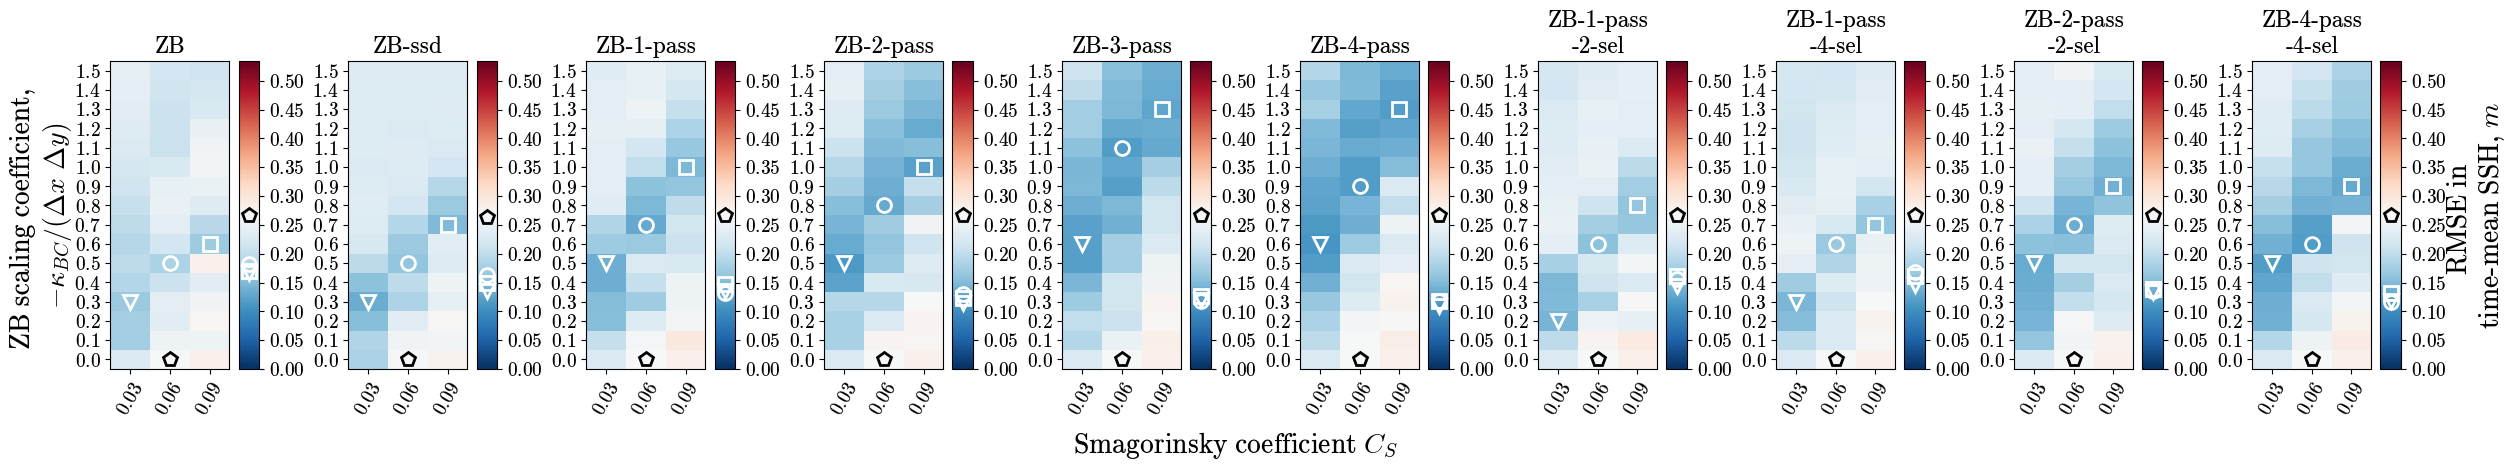

In [55]:
plot_panels(**simple_filters, **ssh)
#plt.savefig('Cs-ZB/simple-ssh.pdf')

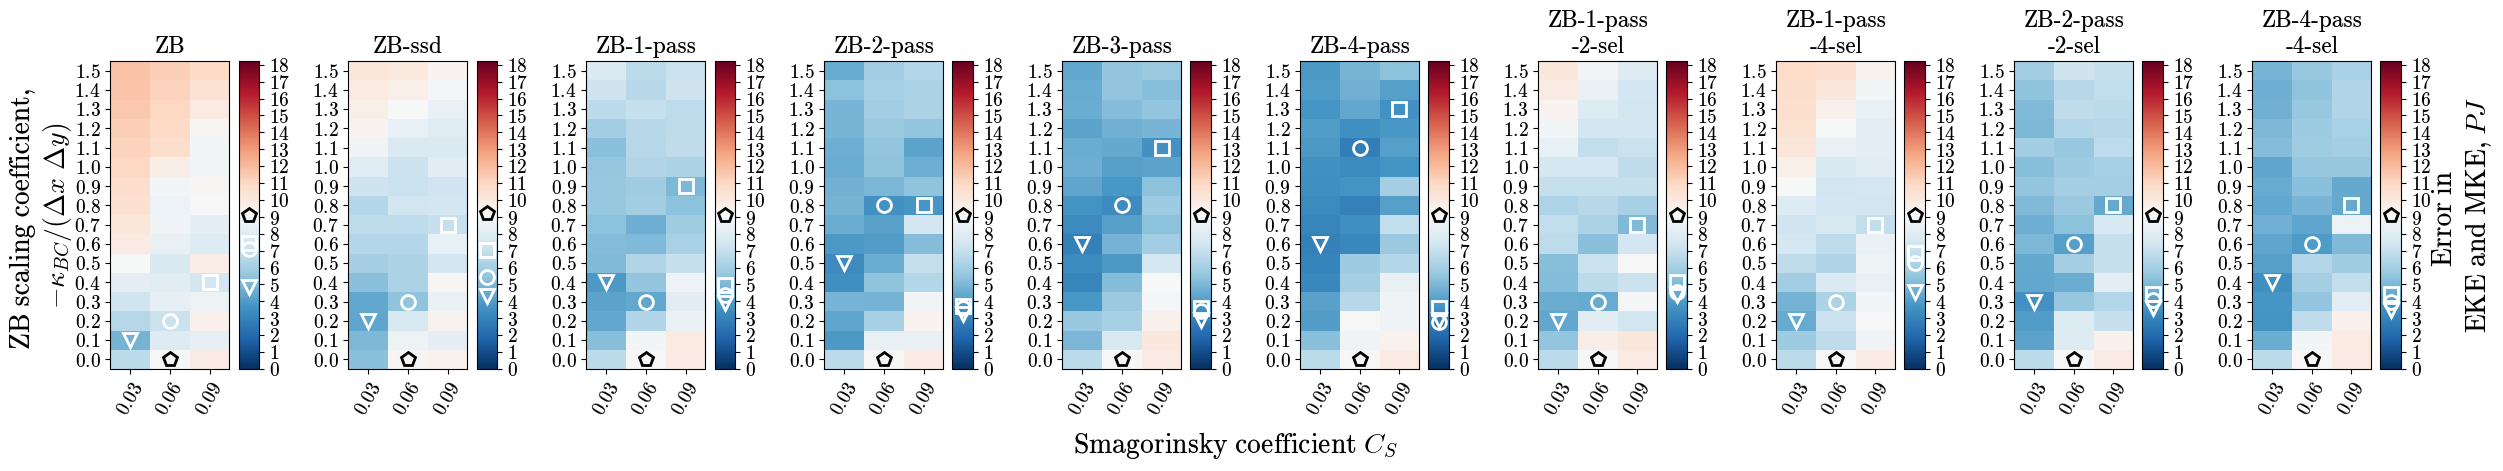

In [19]:
plot_panels(**simple_filters, **energy)

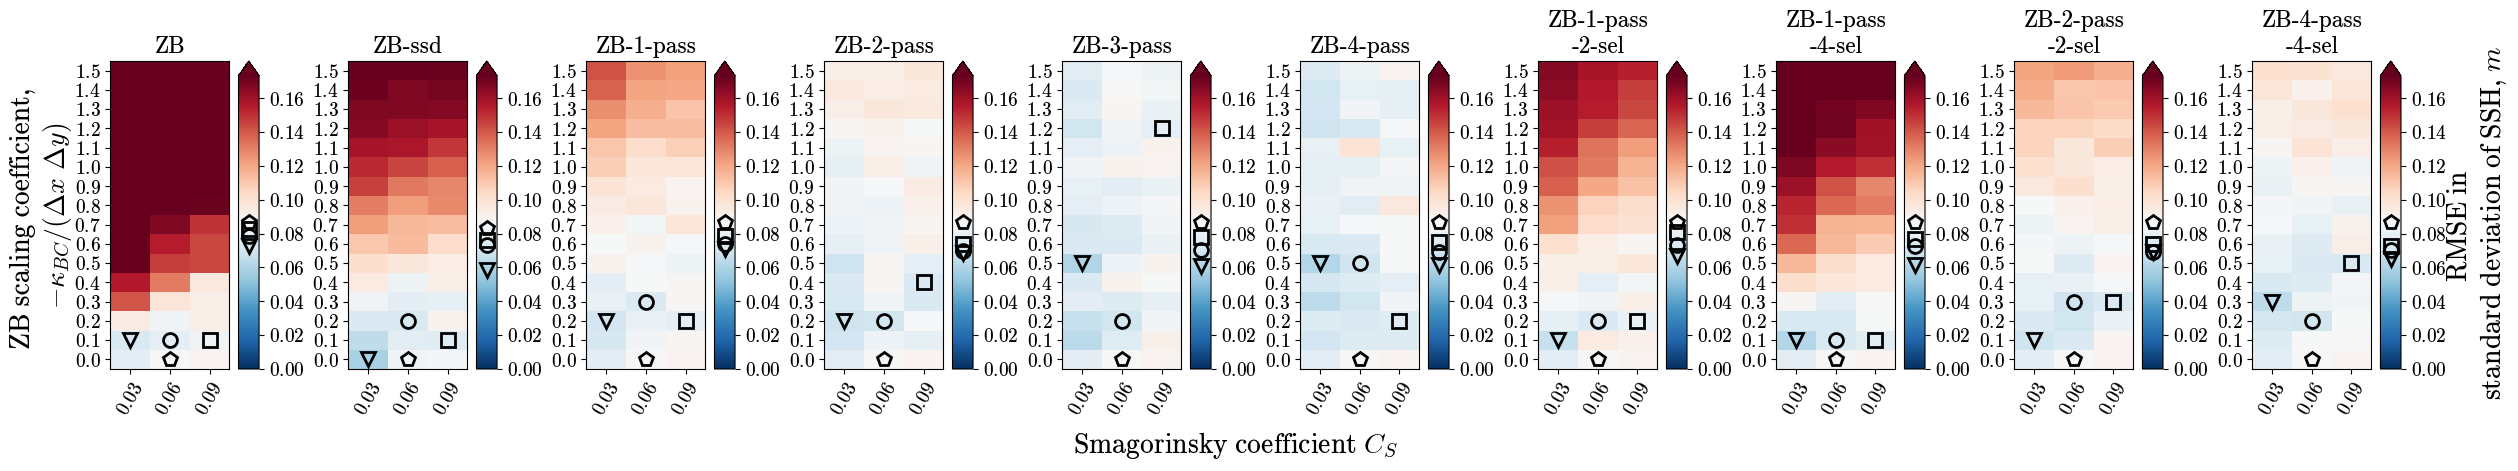

In [170]:
plot_panels(**simple_filters, **ssh_std)
plt.savefig('Cs-ZB/simple-ssh-std.pdf')

# Other experiments

In [173]:
other_models = {'exps': 
       ['ZB-clean', 'ZB-ssd', 'ZB-stress-pass-4-sel-1', 'ZB-ssd-11', 'ZB-VG-pass-2'],
        'labels': 
       ['ZB', 'ZB-ssd', 'ZB-4-pass', 'ZB-ssd-11', 'ZB-VG-pass-2']
        }

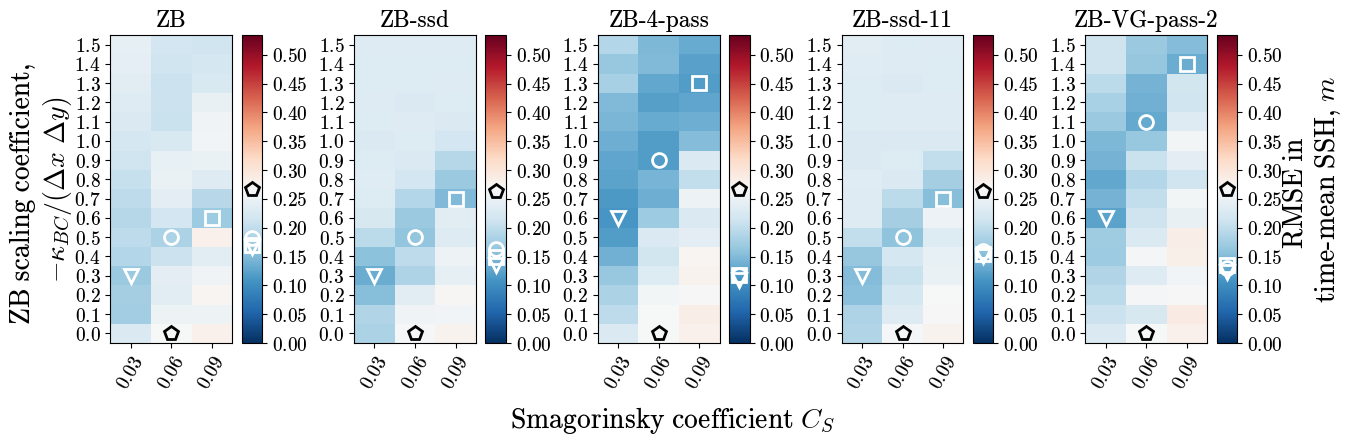

In [174]:
plot_panels(**other_models, **ssh)
plt.savefig('Cs-ZB/other-ssh.pdf')

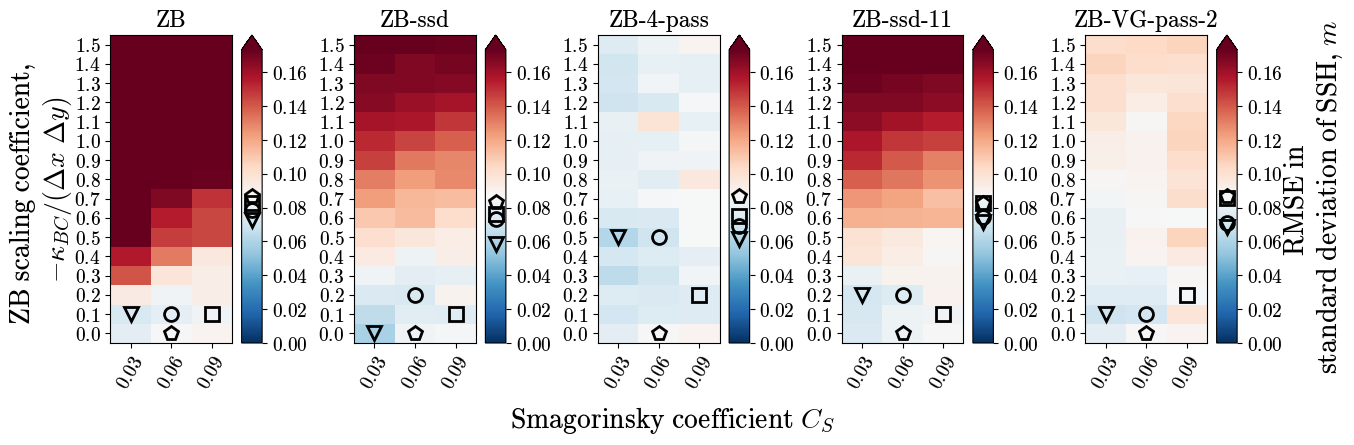

In [175]:
plot_panels(**other_models, **ssh_std)
plt.savefig('Cs-ZB/other-ssh-std.pdf')

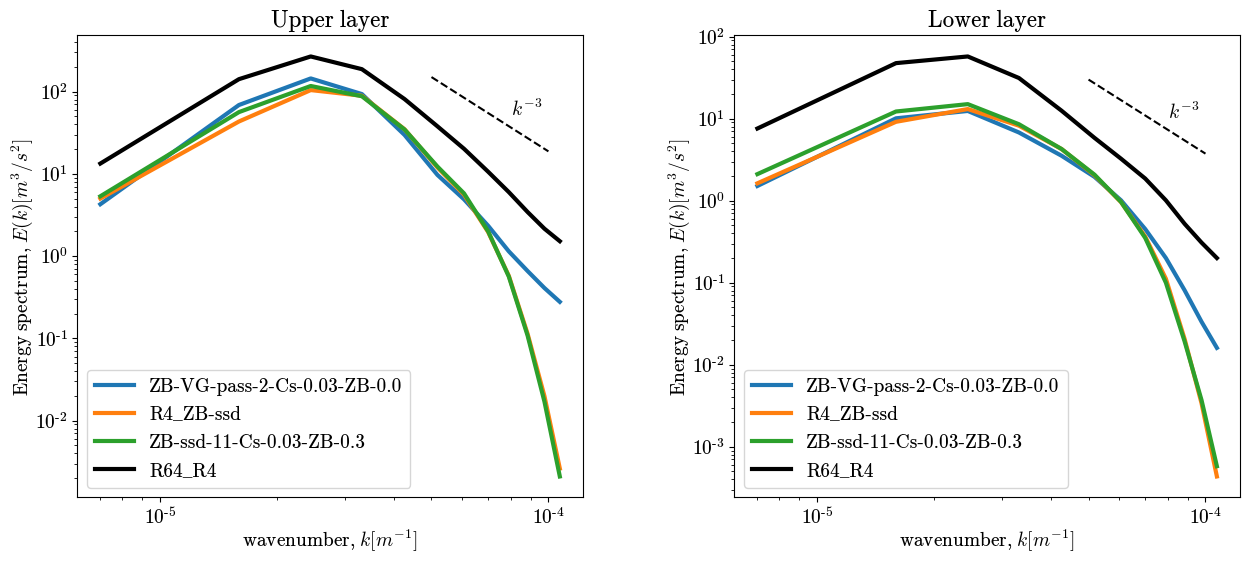

In [69]:
ds.plot_KE_spectrum(['ZB-VG-pass-2-Cs-0.03-ZB-0.0','R4_ZB-ssd', 'ZB-ssd-11-Cs-0.03-ZB-0.3', 'R64_R4'])


In [66]:
Lk_error(ds['R4_ZB-ssd'].ssh_mean,ds['R64_R4'].ssh_mean)

[0.125293]

In [89]:
Lk_error(ds['ZB-ssd-11-Cs-0.03-ZB-0.3'].ssh_mean,ds['R64_R4'].ssh_mean)

[0.15024473]

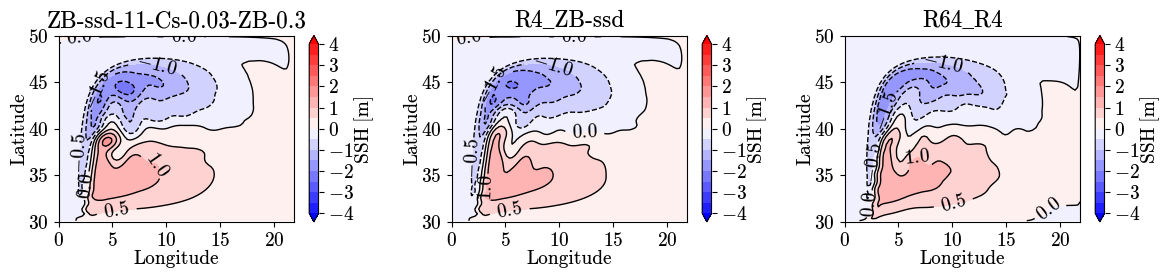

In [87]:
ds.plot_ssh(['ZB-ssd-11-Cs-0.03-ZB-0.3', 'R4_ZB-ssd', 'R64_R4'])

# EXP205

In [143]:
other_models = {'exps': 
       ['ZB-clean', 'ZB-stress-pass-4-sel-1', 'ZB-EXP205'],
        'labels': 
       ['ZB','ZB-4-pass', 'ZB-EXP205']
        }

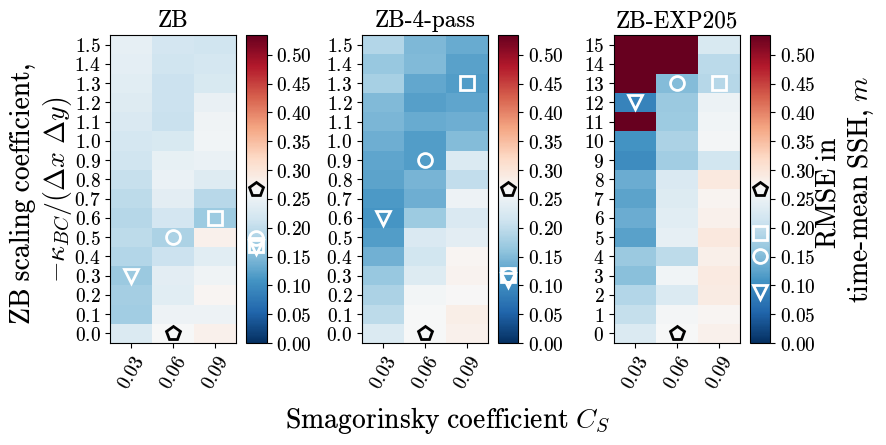

In [144]:
plot_panels(**other_models, **ssh)

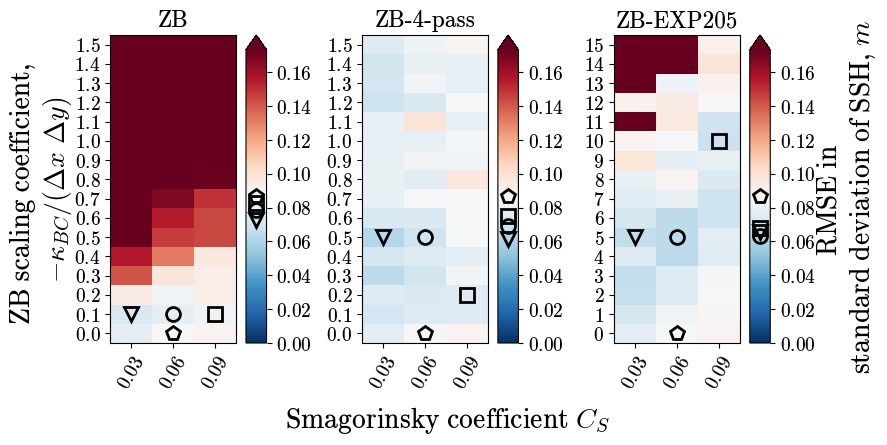

In [145]:
plot_panels(**other_models, **ssh_std)

# Reynolds models

In [ ]:
# other_models = {'exps': 
#        ['ZB-clean', 'ZB-stress-pass-4-sel-1', 'ZB-EXP205', 
#        'ZB-Reynolds-pass-1-sel-1', 'ZB-Reynolds-pass-2-sel-1', 'ZB-Reynolds-pass-4-sel-1', 'ZB-Reynolds-pass-1-sel-2', 'ZB-Reynolds-pass-1-sel-4', 'ZB-Reynolds-pass-2-sel-2', 'ZB-Reynolds-pass-4-sel-4'],
#         'labels': 
#        ['ZB','ZB-4-pass', 'ZB-EXP205',
#        'ZB-R-1-pass', 'ZB-R-2-pass', 'ZB-R-4-pass', 'ZB-R-1-pass\n2-sel', 'ZB-R-1-pass\n4-sel', 'ZB-R-2-pass\n2-sel', 'ZB-R-4-pass\n4-sel']
#         }

In [ ]:
# plot_panels(**other_models, **ssh)

In [ ]:
# plot_panels(**other_models, **ssh_std)

In [ ]:
# ds.plot_KE_spectrum(['ZB-VG-pass-2-Cs-0.03-ZB-0.0','ZB-EXP205-Cs-0.03-ZB-7.0', 'ZB-Reynolds-pass-4-sel-1-Cs-0.03-ZB-2.0', 'R64_R4'])


In [ ]:
# Lk_error(ds['ZB-Reynolds-pass-4-sel-1-Cs-0.03-ZB-2.0'].ssh_mean, ds['R64_R4'].ssh_mean)

# Reynolds models second set

In [ ]:
# other_models = {'exps': 
#        ['ZB-clean', 'ZB-stress-pass-4-sel-1', 'ZB-EXP205', 
#        'ZB-Reynolds-VG-smooth-pass-1-sel-1', 'ZB-Reynolds-VG-smooth-pass-2-sel-1', 'ZB-Reynolds-VG-smooth-pass-4-sel-1', 'ZB-Reynolds-VG-smooth-pass-1-sel-2', 'ZB-Reynolds-VG-smooth-pass-1-sel-4', 'ZB-Reynolds-VG-smooth-pass-2-sel-2', 'ZB-Reynolds-VG-smooth-pass-4-sel-4'],
#         'labels': 
#        ['ZB','ZB-4-pass', 'ZB-EXP205',
#        'ZB-RV-1-pass', 'ZB-RV-2-pass', 'ZB-RV-4-pass', 'ZB-RV-1-pass\n2-sel', 'ZB-RV-1-pass\n4-sel', 'ZB-RV-2-pass\n2-sel', 'ZB-RV-4-pass\n4-sel']
#         }

In [154]:
# plot_panels(**other_models, **ssh)

In [152]:
# plot_panels(**other_models, **ssh_std)

In [153]:
# ds.plot_KE_spectrum(['ZB-VG-pass-2-Cs-0.03-ZB-0.0','ZB-EXP205-Cs-0.03-ZB-7.0', 'ZB-Reynolds-pass-4-sel-1-Cs-0.03-ZB-2.0','ZB-Reynolds-VG-smooth-pass-4-sel-4-Cs-0.03-ZB-15.0', 'R64_R4'], labels=['R4', 'EXP205', 'Reynolds4-1', 'Reynolds-VG-4-1', 'Ref'])


# Reynolds models change range

In [176]:
other_models = {'exps': 
       ['ZB-clean', 'ZB-stress-pass-4-sel-1', 'ZB-EXP205', 
       'ZB-Reynolds-pass-1-sel-1-range', 'ZB-Reynolds-pass-2-sel-1-range', 'ZB-Reynolds-pass-4-sel-1-range', 'ZB-Reynolds-pass-1-sel-2-range', 'ZB-Reynolds-pass-1-sel-4-range', 'ZB-Reynolds-pass-2-sel-2-range', 'ZB-Reynolds-pass-4-sel-4-range'],
        'labels': 
       ['ZB','ZB-4-pass', 'ZB-EXP205',
       'ZB-R-1-pass', 'ZB-R-2-pass', 'ZB-R-4-pass', 'ZB-R-1-pass\n2-sel', 'ZB-R-1-pass\n4-sel', 'ZB-R-2-pass\n2-sel', 'ZB-R-4-pass\n4-sel']
        }

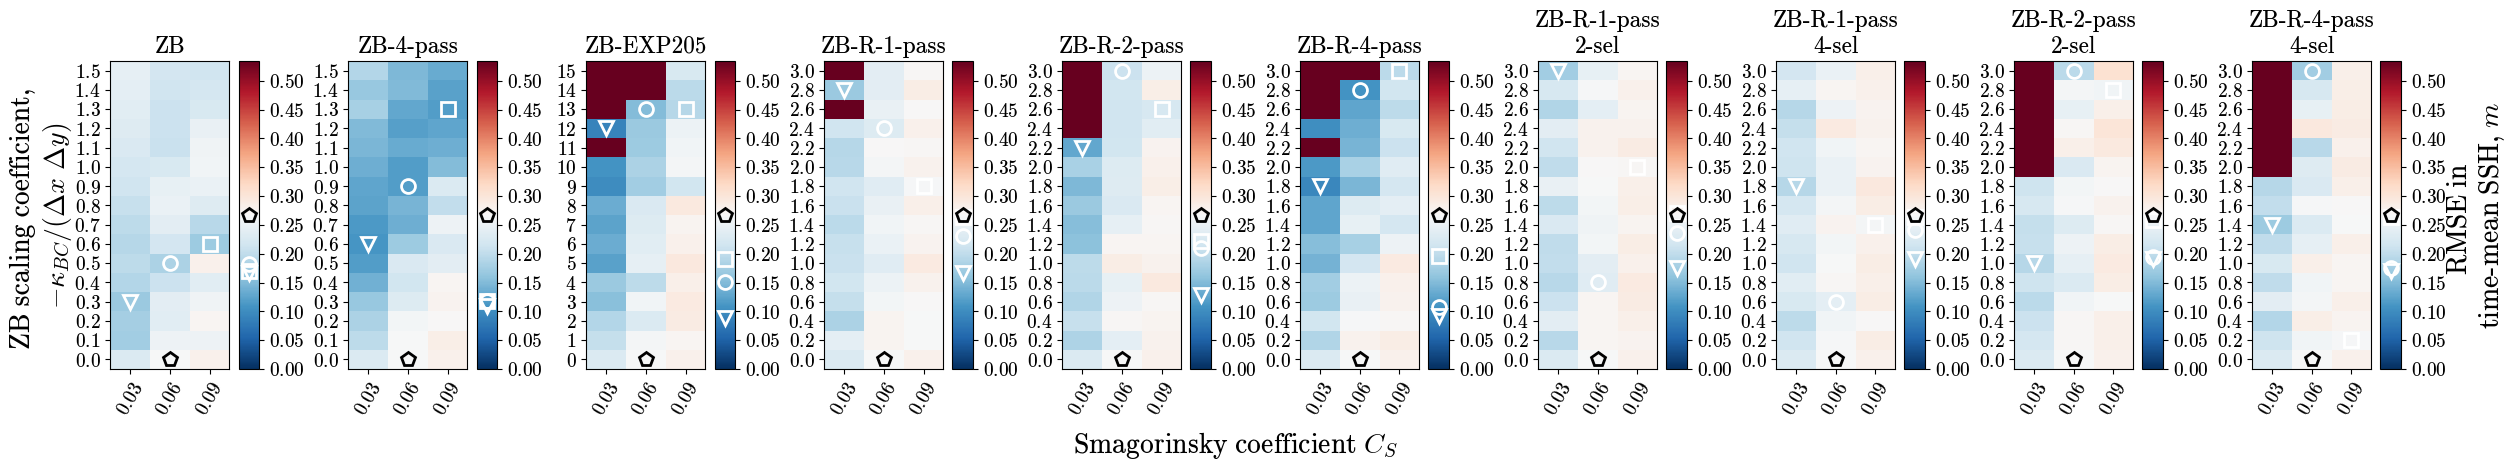

In [177]:
plot_panels(**other_models, **ssh)
plt.savefig('Cs-ZB/reynolds-ssh.pdf')

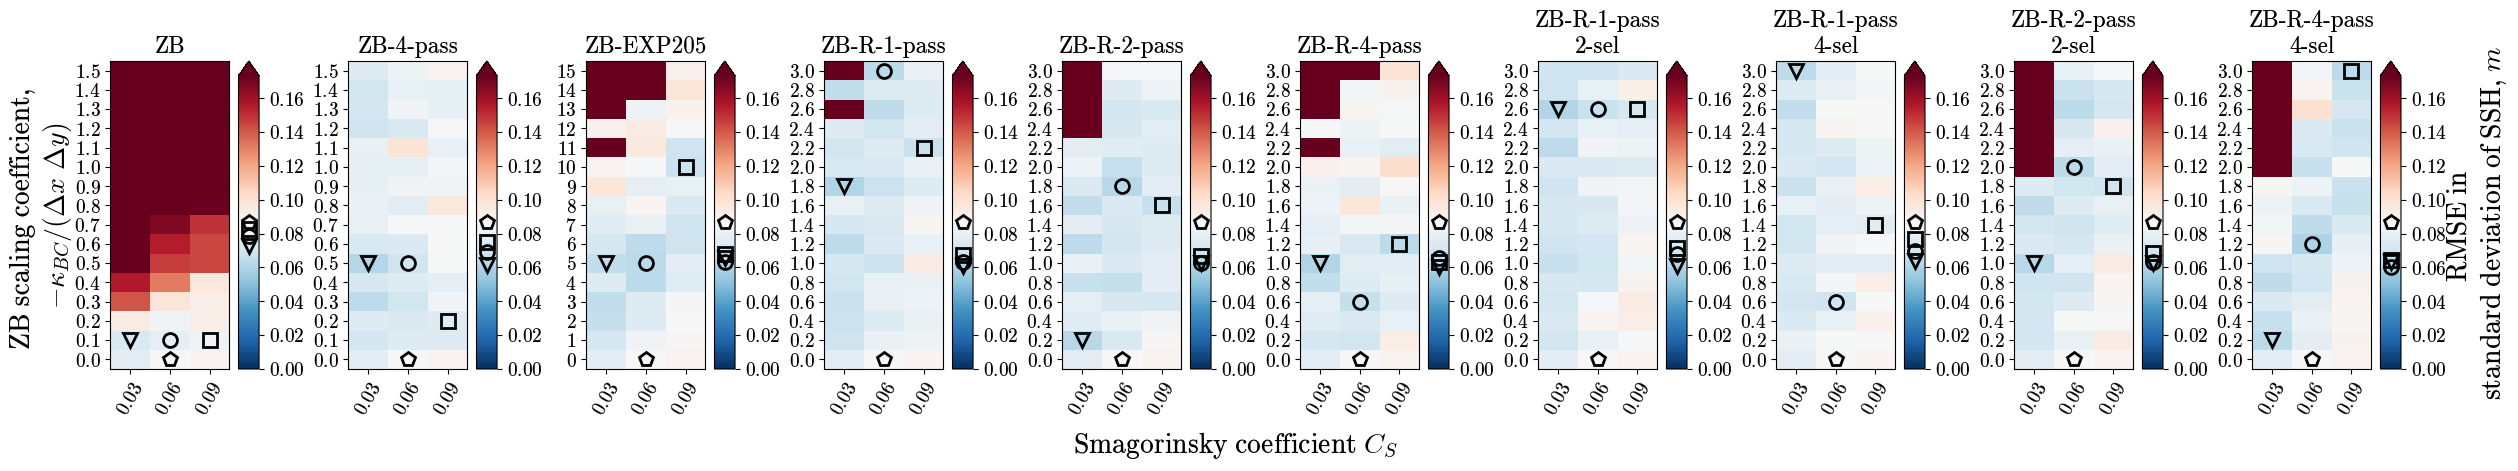

In [178]:
plot_panels(**other_models, **ssh_std)
plt.savefig('Cs-ZB/reynolds-ssh-std.pdf')

In [160]:
# ds.plot_KE_spectrum(['ZB-VG-pass-2-Cs-0.03-ZB-0.0','ZB-EXP205-Cs-0.03-ZB-7.0', 'ZB-Reynolds-pass-4-sel-1-range-Cs-0.03-ZB-1.8', 'ZB-Reynolds-pass-4-sel-1-range-Cs-0.06-ZB-2.8', 'R64_R4'], labels=['R4', 'EXP205', 'Reynolds4-1', 'Reynolds-4-1-Cs-0.06', 'Ref'])


In [161]:
# ds.plot_KE_spectrum(['ZB-VG-pass-2-Cs-0.03-ZB-0.0','ZB-EXP205-Cs-0.03-ZB-7.0', 'ZB-Reynolds-pass-4-sel-1-range-Cs-0.03-ZB-1.8', 'ZB-Reynolds-pass-4-sel-1-range-Cs-0.06-ZB-2.8', 'R64'], labels=['R4', 'EXP205', 'Reynolds4-1', 'Reynolds-4-1-Cs-0.06', 'Ref'], key='KE_spectrum_global')


In [162]:
# ds.plot_ssh(['ZB-VG-pass-2-Cs-0.03-ZB-0.0','ZB-EXP205-Cs-0.03-ZB-7.0', 'ZB-Reynolds-pass-4-sel-1-range-Cs-0.06-ZB-2.8', 'R64_R4'], labels=['R4', 'EXP205', 'Reynolds4-1', 'Ref'])


# Filtered Reynolds models

In [179]:
other_models = {'exps': 
       ['ZB-clean', 'ZB-stress-pass-4-sel-1', 'ZB-EXP205', 
       'ZB-Reynolds-VG-smooth-pass-1-sel-1-range', 'ZB-Reynolds-VG-smooth-pass-2-sel-1-range', 'ZB-Reynolds-VG-smooth-pass-4-sel-1-range', 'ZB-Reynolds-VG-smooth-pass-1-sel-2-range', 'ZB-Reynolds-VG-smooth-pass-1-sel-4-range', 'ZB-Reynolds-VG-smooth-pass-2-sel-2-range', 'ZB-Reynolds-VG-smooth-pass-4-sel-4-range'],
        'labels': 
       ['ZB','ZB-4-pass', 'ZB-EXP205',
       'ZB-RV-1-pass', 'ZB-RV-2-pass', 'ZB-RV-4-pass', 'ZB-RV-1-pass\n2-sel', 'ZB-RV-1-pass\n4-sel', 'ZB-RV-2-pass\n2-sel', 'ZB-RV-4-pass\n4-sel']
        }

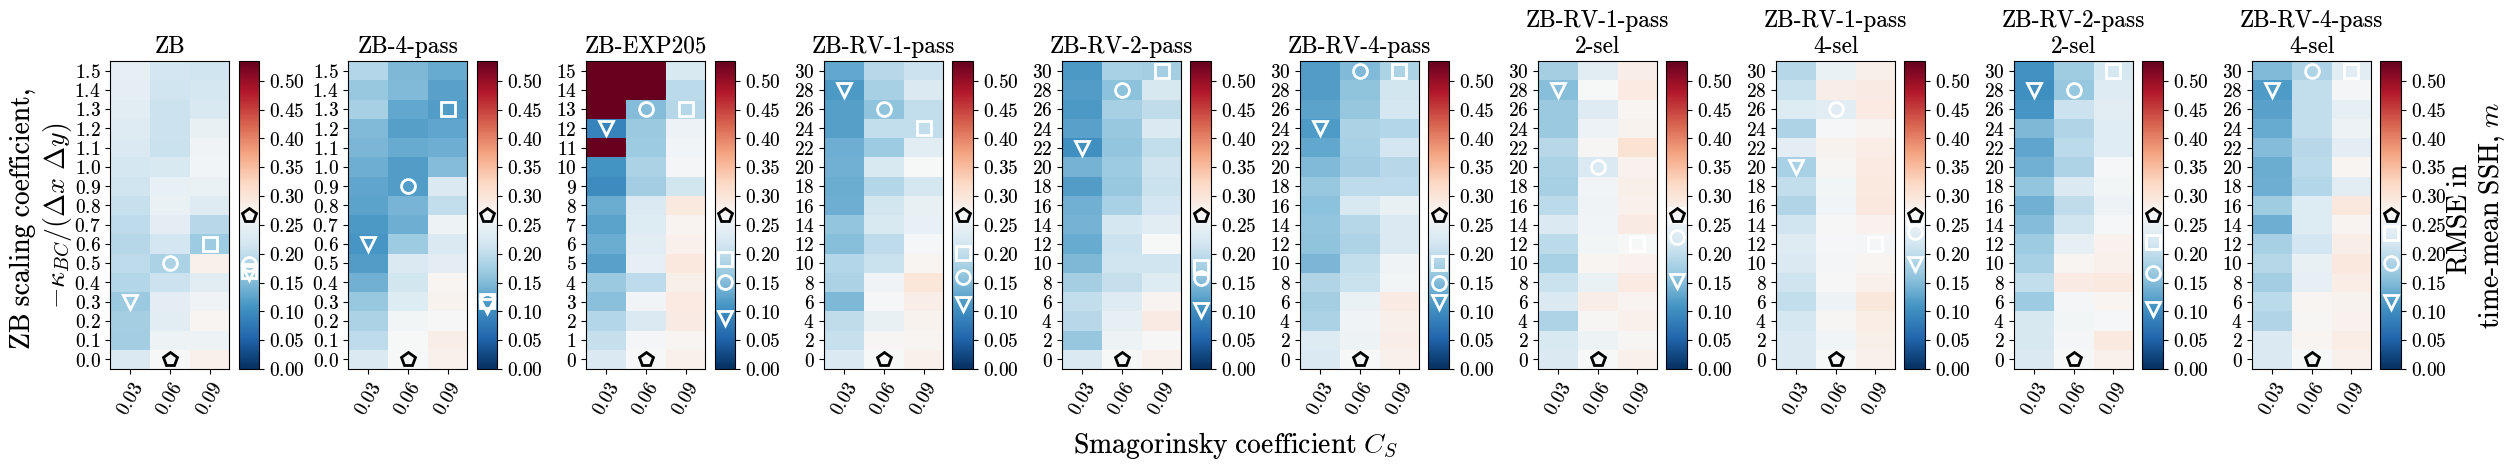

In [180]:
plot_panels(**other_models, **ssh)
plt.savefig('Cs-ZB/reynolds-VG-ssh.pdf')

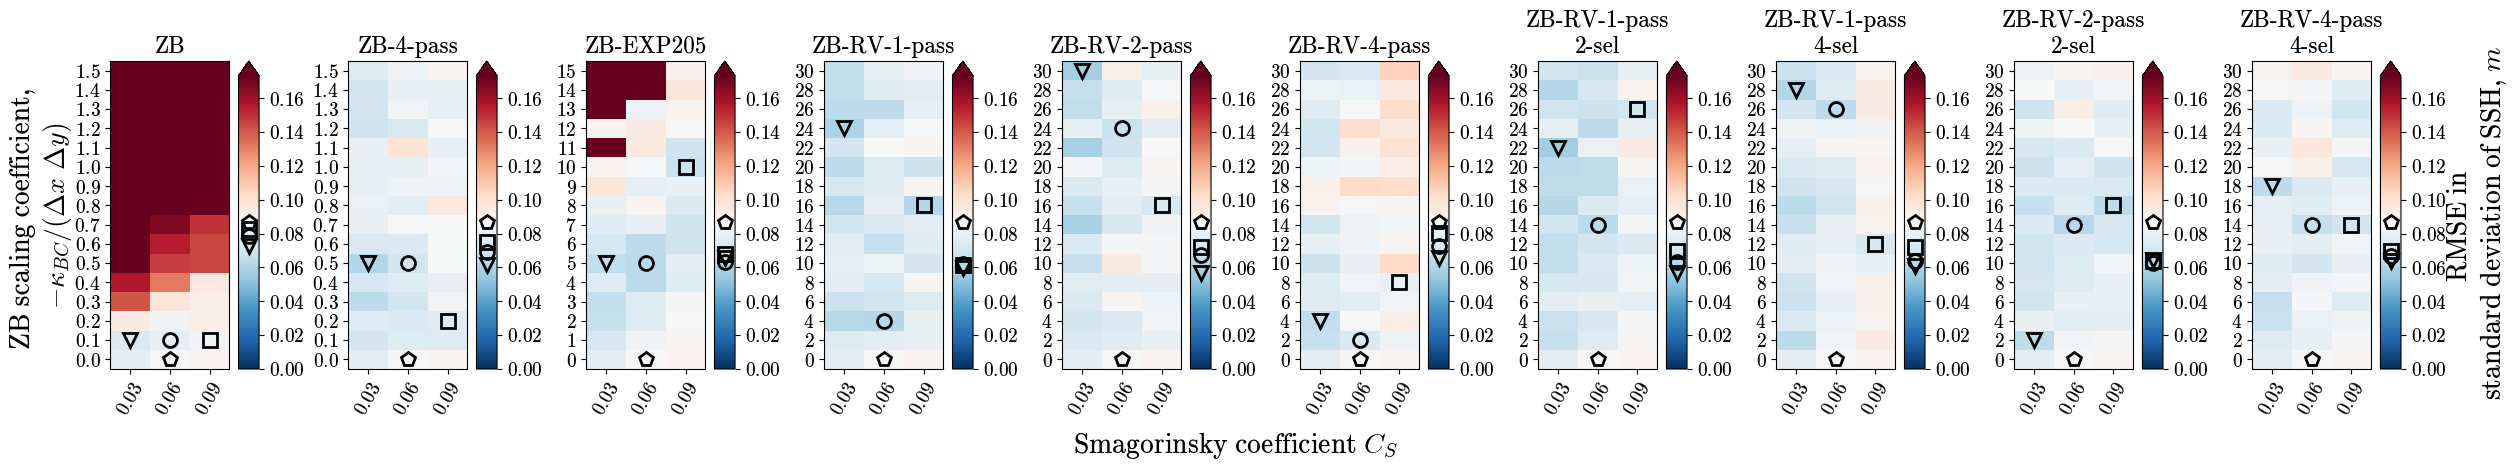

In [181]:
plot_panels(**other_models, **ssh_std)
plt.savefig('Cs-ZB/reynolds-VG-ssh-std.pdf')

# Spectrum

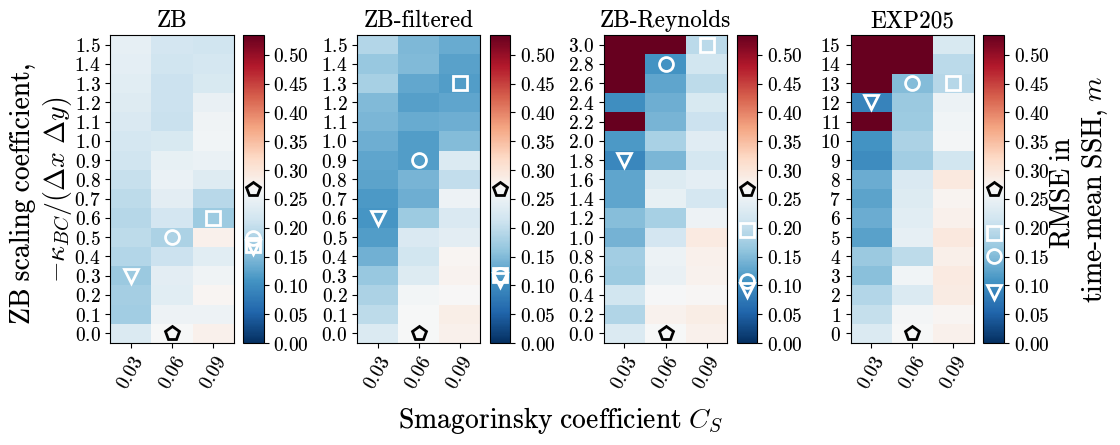

In [268]:
plot_panels(exps=['ZB-clean', 'ZB-stress-pass-4-sel-1', 'ZB-Reynolds-pass-4-sel-1-range', 'ZB-EXP205'], labels=['ZB', 'ZB-filtered', 'ZB-Reynolds', 'EXP205'], **ssh)


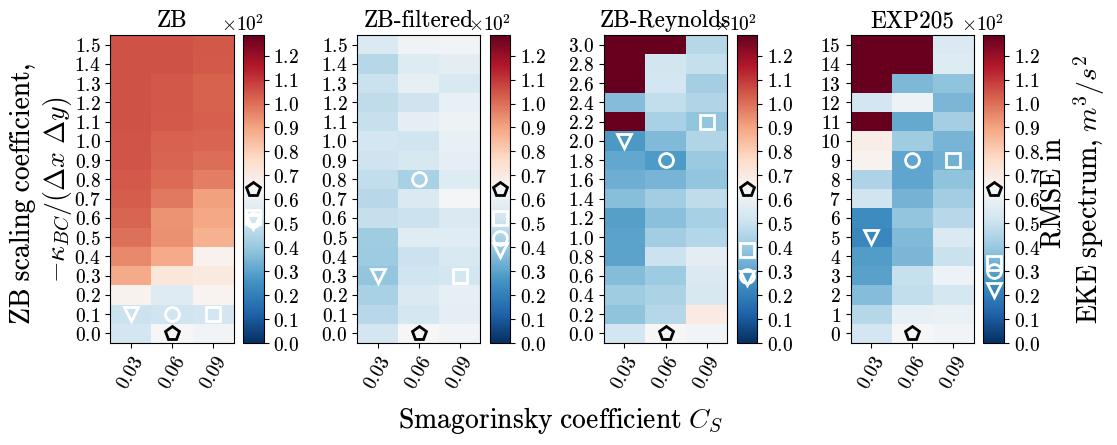

In [273]:
plot_panels(exps=['ZB-clean', 'ZB-stress-pass-4-sel-1', 'ZB-Reynolds-pass-4-sel-1-range', 'ZB-EXP205'], labels=['ZB', 'ZB-filtered', 'ZB-Reynolds', 'EXP205'], **sp)


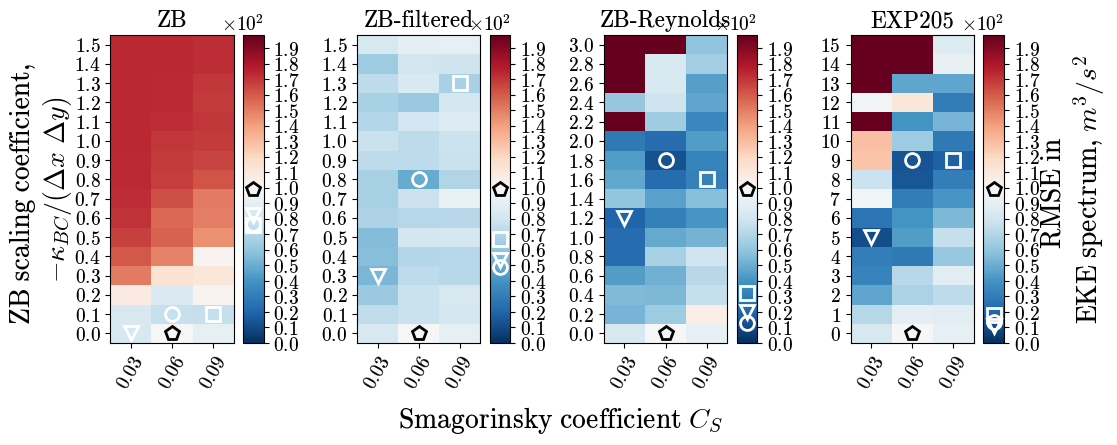

In [271]:
p = sp.copy()
p['error_function'] = error_spectrum_large
p['v0'] = 99.26127116294647
p['cbar_ticks'] = np.arange(0,200,10)
plot_panels(exps=['ZB-clean', 'ZB-stress-pass-4-sel-1', 'ZB-Reynolds-pass-4-sel-1-range', 'ZB-EXP205'], labels=['ZB', 'ZB-filtered', 'ZB-Reynolds', 'EXP205'], **p)

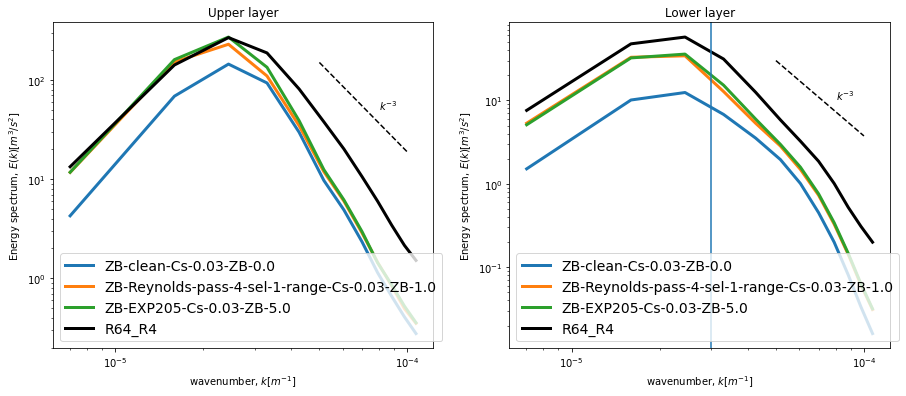

In [21]:
ds.plot_KE_spectrum(['ZB-clean-Cs-0.03-ZB-0.0', 'ZB-Reynolds-pass-4-sel-1-range-Cs-0.03-ZB-1.0', 'ZB-EXP205-Cs-0.03-ZB-5.0', 'R64_R4'])

plt.axvline(x=3e-5)

# Possibly simpler Reynolds models

In [32]:
reynolds = {'exps':
           ['ZB-EXP205', 'ZB-Reynolds-pass-4-pass-4', 'ZB-Reynolds-pass-4-pass-2', 'ZB-Reynolds-pass-4-pass-1', 'ZB-Reynolds-pass-4-pass-1-sel-2'],
           'labels':
           ['EXP205', 'Reynolds-4-4', 'Reynolds-4-2', 'Reynolds-4-1', 'Reynolds-4-1-2']}


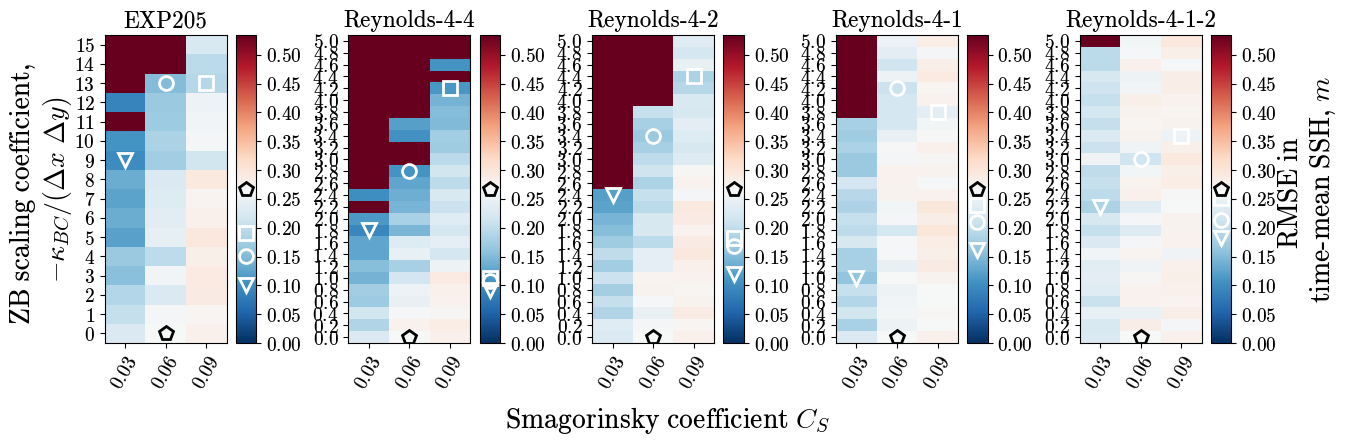

In [33]:
plot_panels(**reynolds, **ssh)
plt.savefig('lox.pdf')

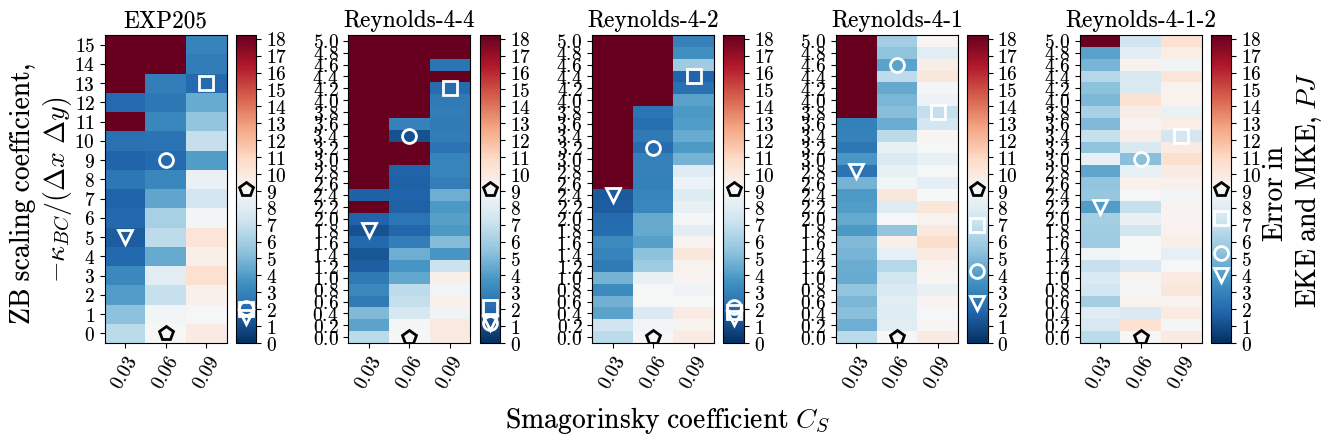

In [50]:
plot_panels(**reynolds, **energy)

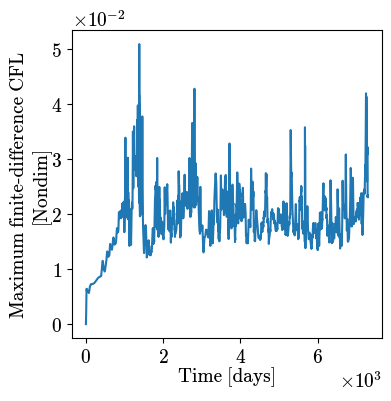

In [96]:
# ds['ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-3.2'].series.KE.isel(Layer=0).plot()
# ds['ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-3.2'].series.KE.isel(Layer=1).plot()
# ds['ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-3.2'].series.APE.isel(Interface=0).plot()
# ds['ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-3.2'].series.APE.isel(Interface=1).plot()
ds['ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-3.4'].series.max_CFL_lin.plot()

In [85]:
ds['ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-3.2'].series.max_CFL_lin

<xarray.DataArray 'max_CFL_lin' (Time: 5280)>
array([0.      , 0.000504, 0.000968, ..., 0.045764, 0.049937, 0.093513])
Coordinates:
  * Time     (Time) float64 0.0 1.0 2.0 3.0 ... 5.277e+03 5.278e+03 5.279e+03
Attributes:
    long_name:  Maximum finite-difference CFL
    units:      Nondim

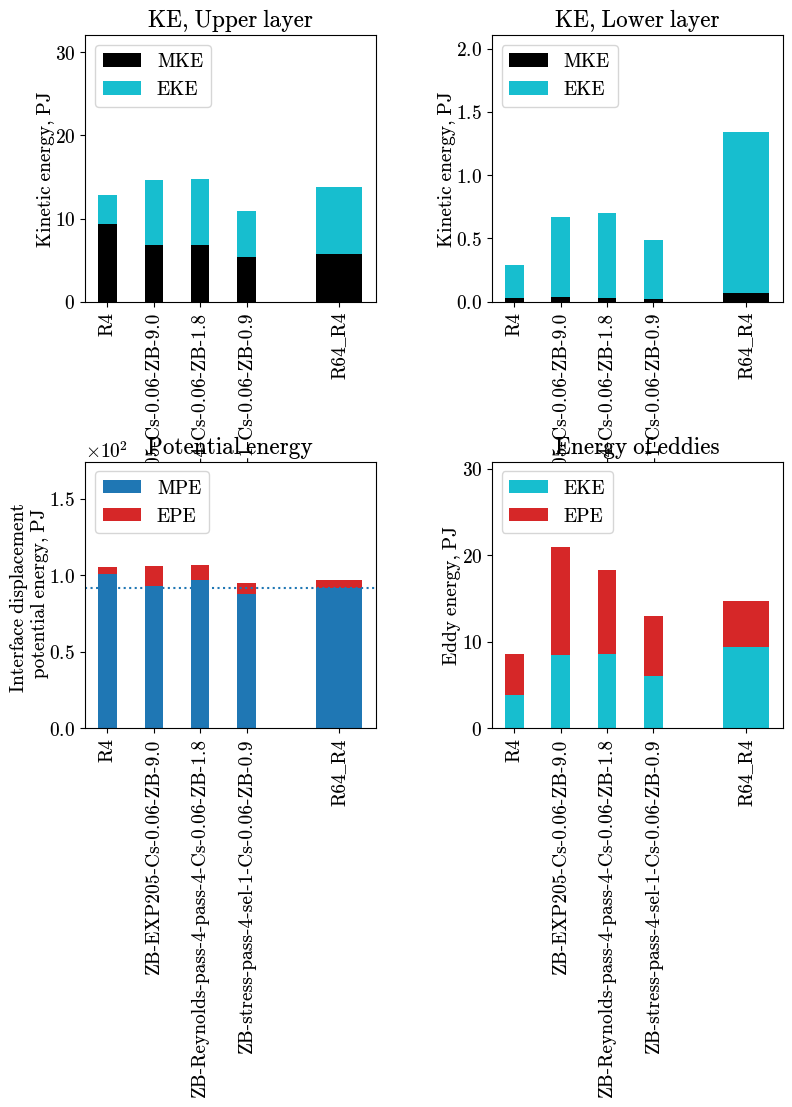

In [61]:
ds.plot_KE_PE(['R4', 'ZB-EXP205-Cs-0.06-ZB-9.0', 'ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-1.8', 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-0.9', 'R64_R4'])

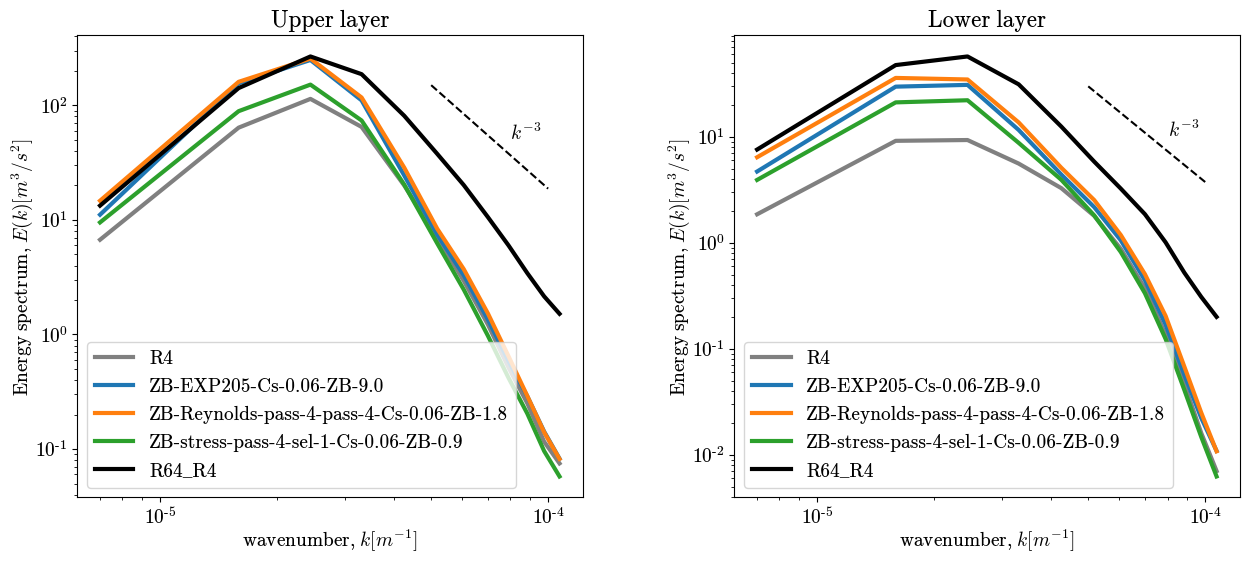

In [68]:
ds.plot_KE_spectrum(['R4', 'ZB-EXP205-Cs-0.06-ZB-9.0', 'ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-1.8', 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-0.9', 'R64_R4'])

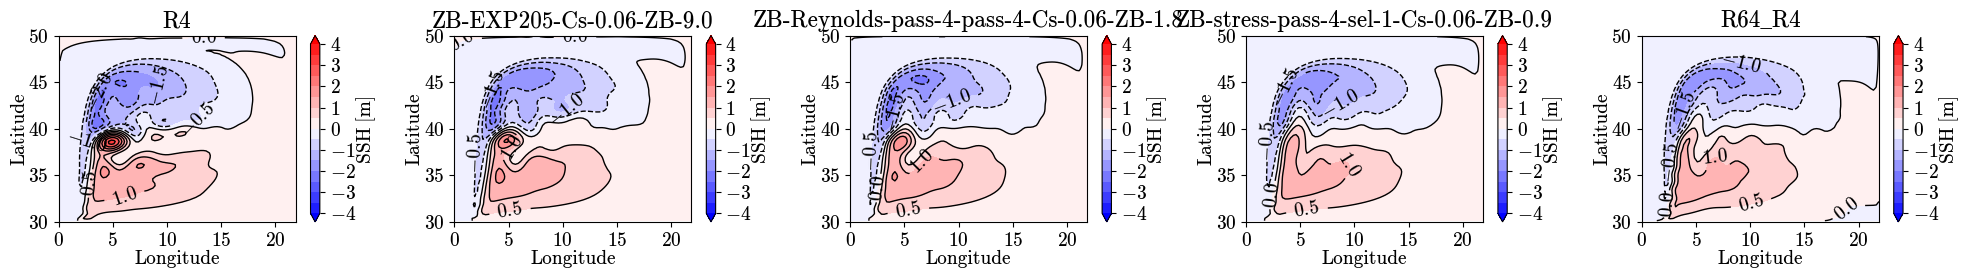

In [65]:
ds.plot_ssh(['R4', 'ZB-EXP205-Cs-0.06-ZB-9.0', 'ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-1.8', 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-0.9', 'R64_R4'])



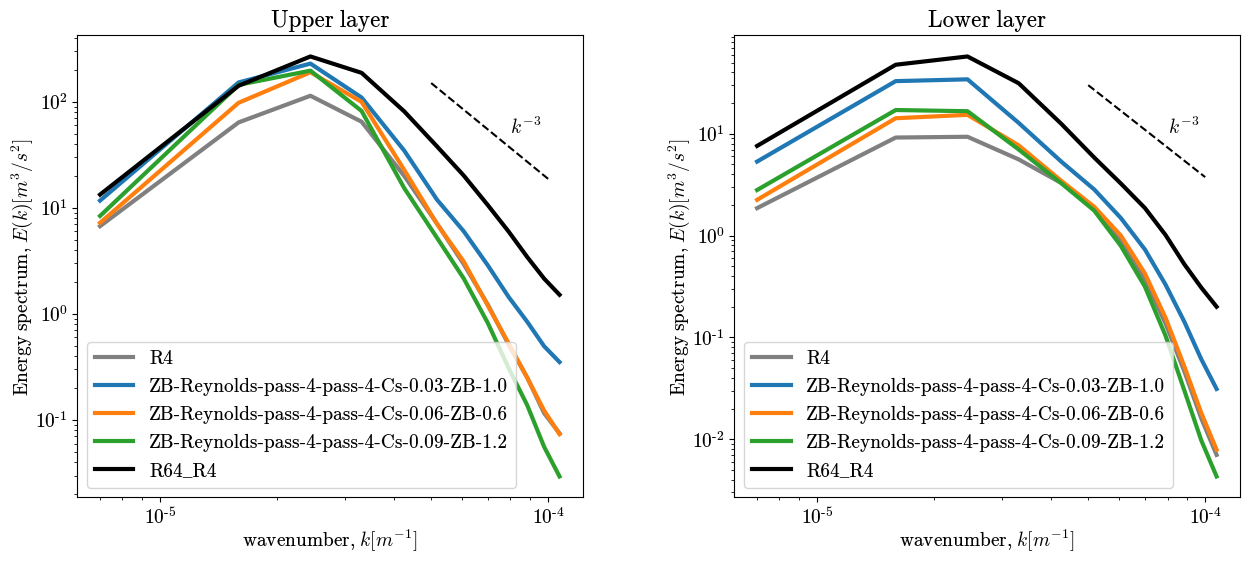

In [74]:
ds.plot_KE_spectrum(['R4','ZB-Reynolds-pass-4-pass-4-Cs-0.03-ZB-1.0', 'ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-0.6', 'ZB-Reynolds-pass-4-pass-4-Cs-0.09-ZB-1.2', 'R64_R4'])


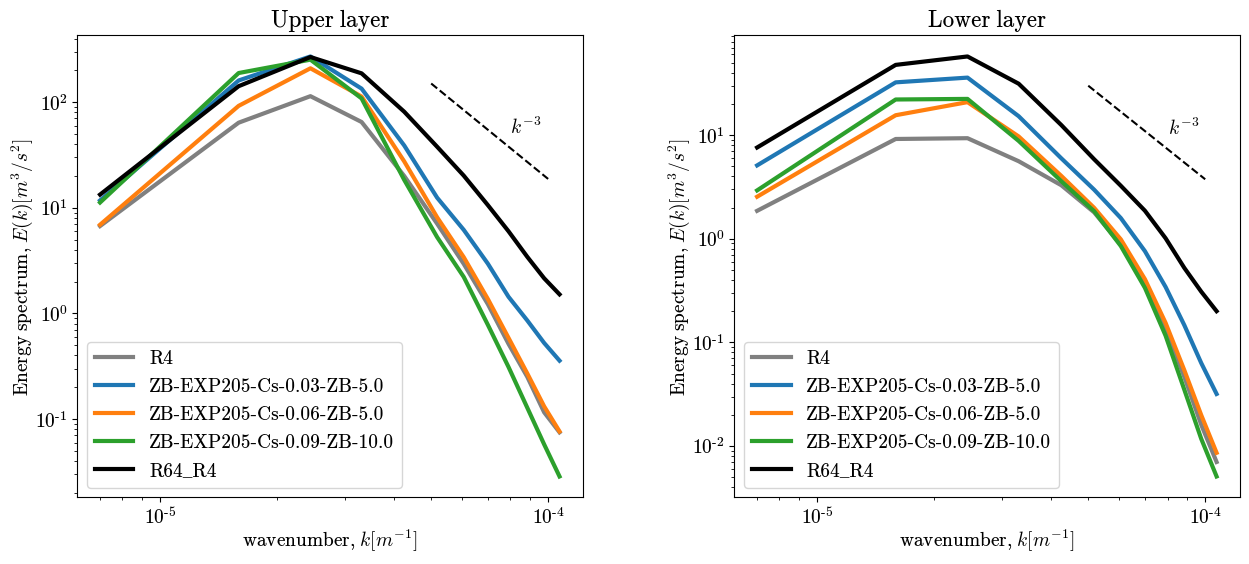

In [75]:
ds.plot_KE_spectrum(['R4', 'ZB-EXP205-Cs-0.03-ZB-5.0', 'ZB-EXP205-Cs-0.06-ZB-5.0', 'ZB-EXP205-Cs-0.09-ZB-10.0', 'R64_R4'])


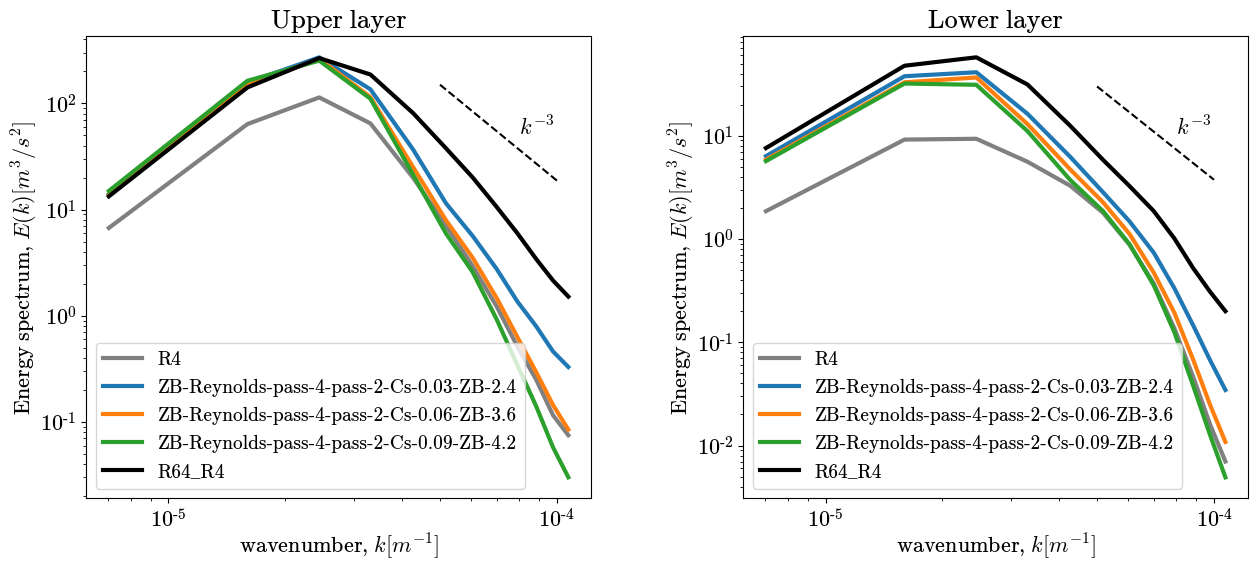

In [72]:
ds.plot_KE_spectrum(['R4','ZB-Reynolds-pass-4-pass-2-Cs-0.03-ZB-2.4', 'ZB-Reynolds-pass-4-pass-2-Cs-0.06-ZB-3.6', 'ZB-Reynolds-pass-4-pass-2-Cs-0.09-ZB-4.2', 'R64_R4'])


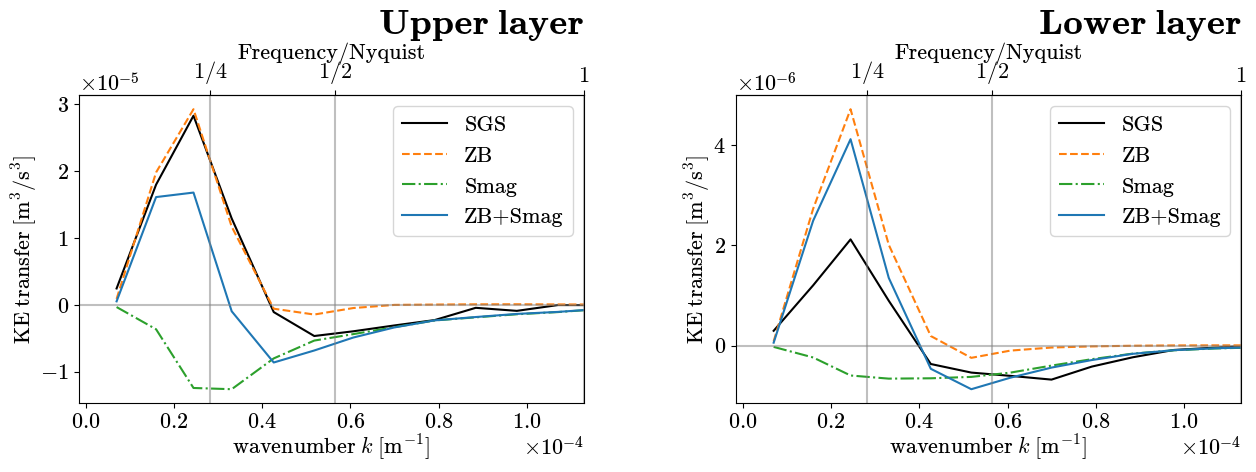

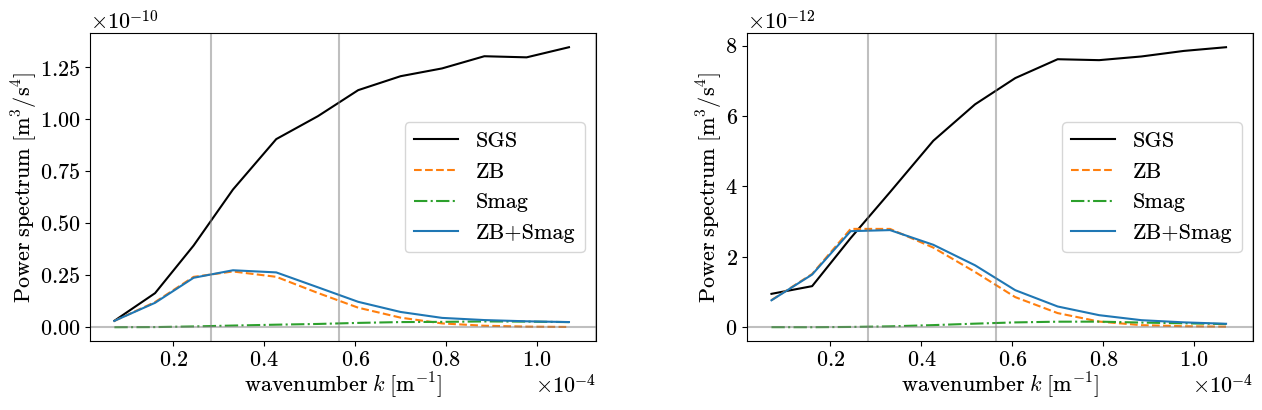

In [66]:
ds.plot_transfer('ZB-EXP205-Cs-0.03-ZB-5.0')

In [69]:
#ds.plot_transfer('ZB-EXP205-Cs-0.09-ZB-9.0')

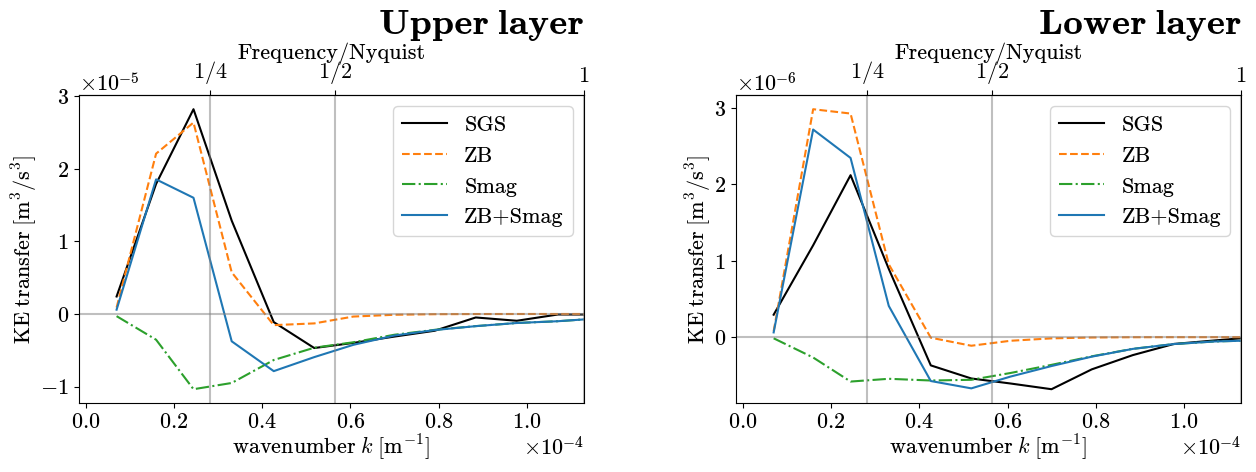

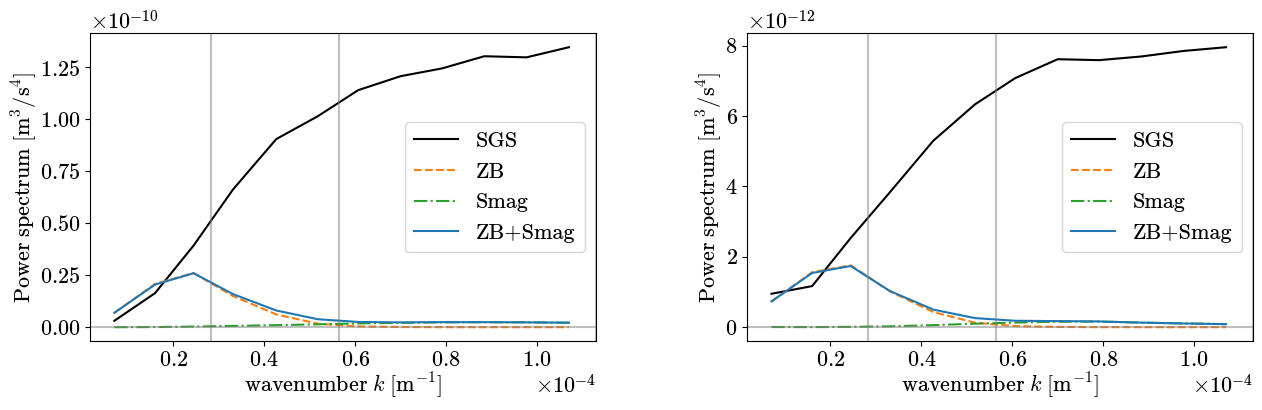

In [68]:
ds.plot_transfer('ZB-Reynolds-pass-4-pass-4-Cs-0.03-ZB-1.2')

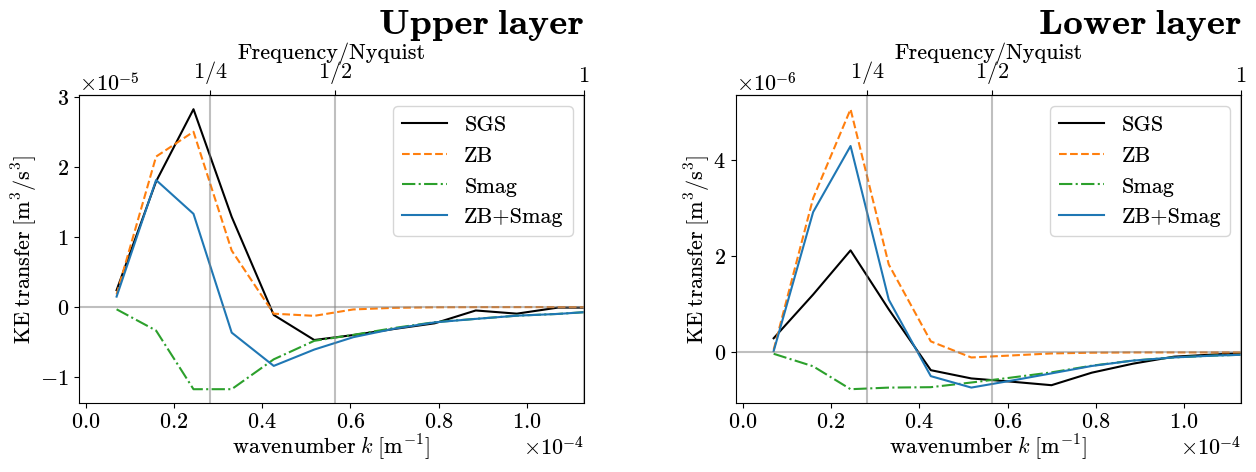

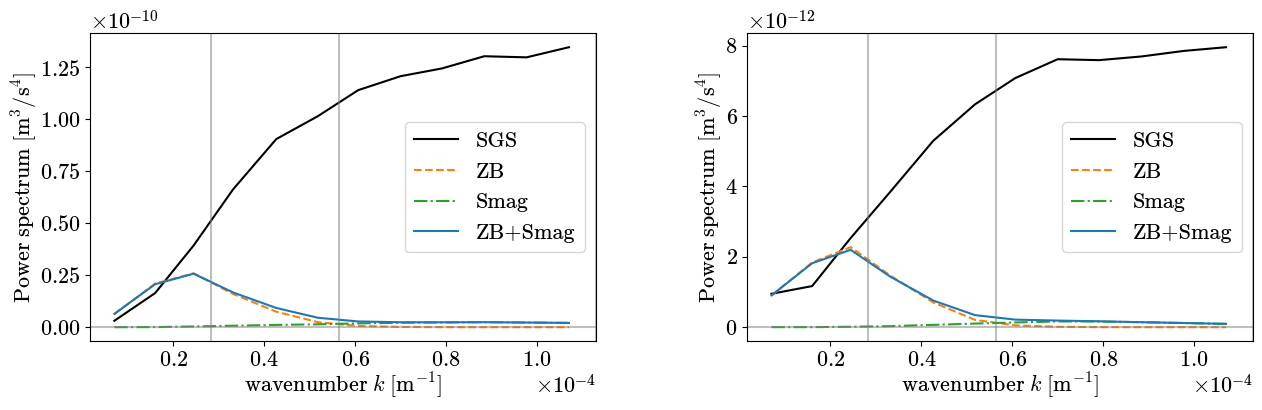

In [70]:
ds.plot_transfer('ZB-Reynolds-pass-4-pass-2-Cs-0.03-ZB-2.4')

# Final models

In [55]:
models = {'exps': 
       ['ZB-clean','ZB-stress-pass-4-sel-1', 'ZB-stress-pass-1-sel-1', 'ZB-stress-pass-2-sel-1', 'ZB-Reynolds-pass-4-pass-4', 'ZB-EXP205'],
        'labels': 
       ['ZB', 'ZB-4-pass', 'ZB-1-pass', 'ZB-2-pass', 'ZB-Reynolds', 'ZB-EXP205']
        }

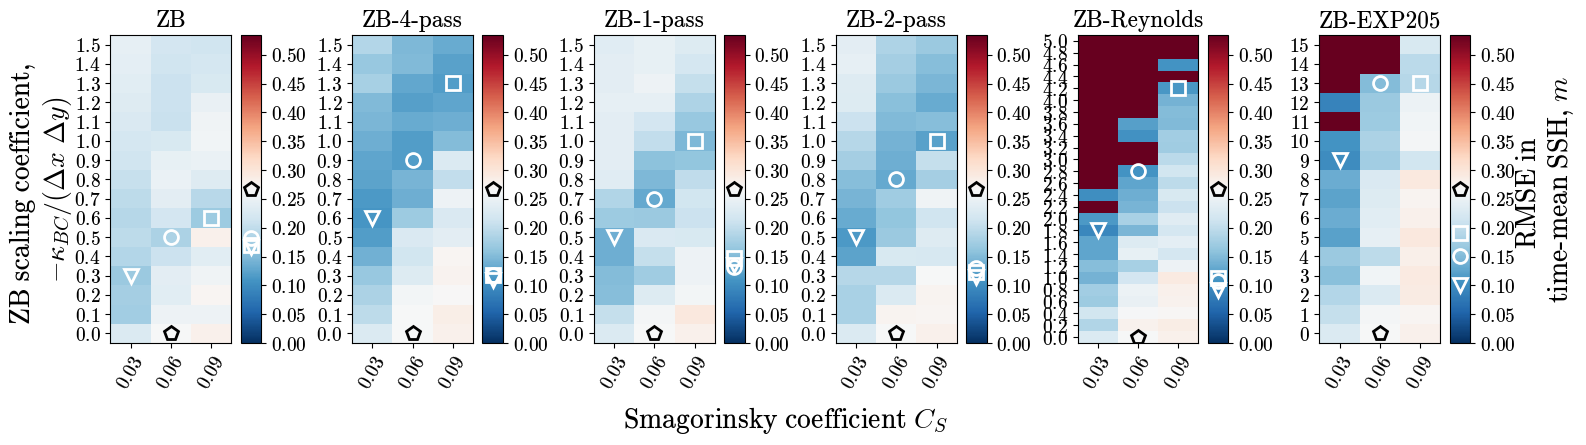

In [34]:
plot_panels(**models, **ssh)

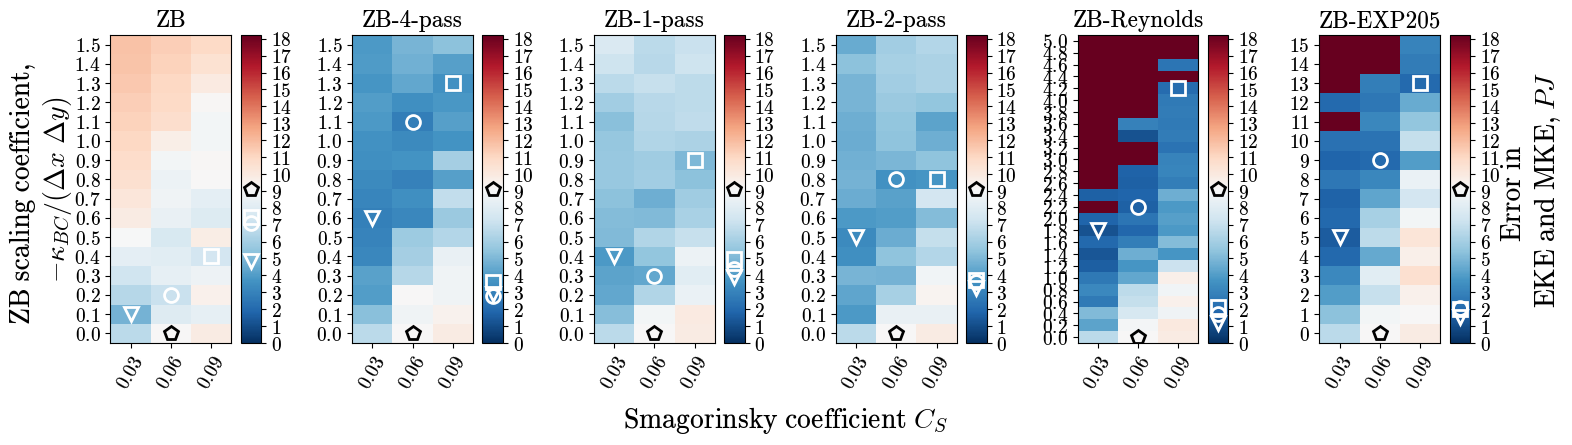

In [50]:
plot_panels(**models, **energy)

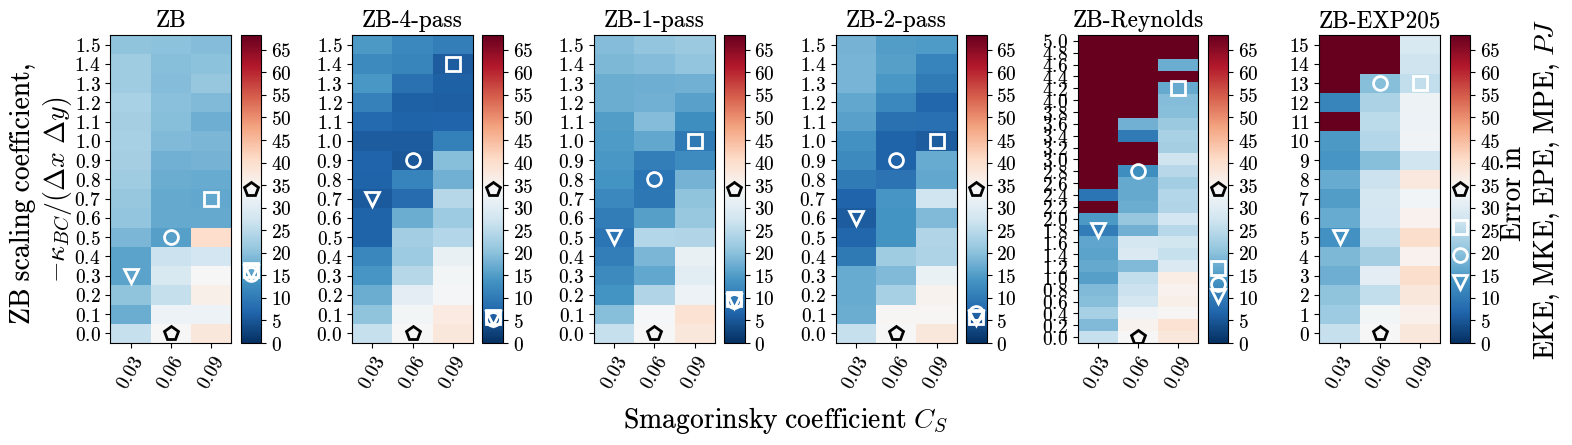

In [56]:
plot_panels(**models, **tot_energy)

# Cs=0.03

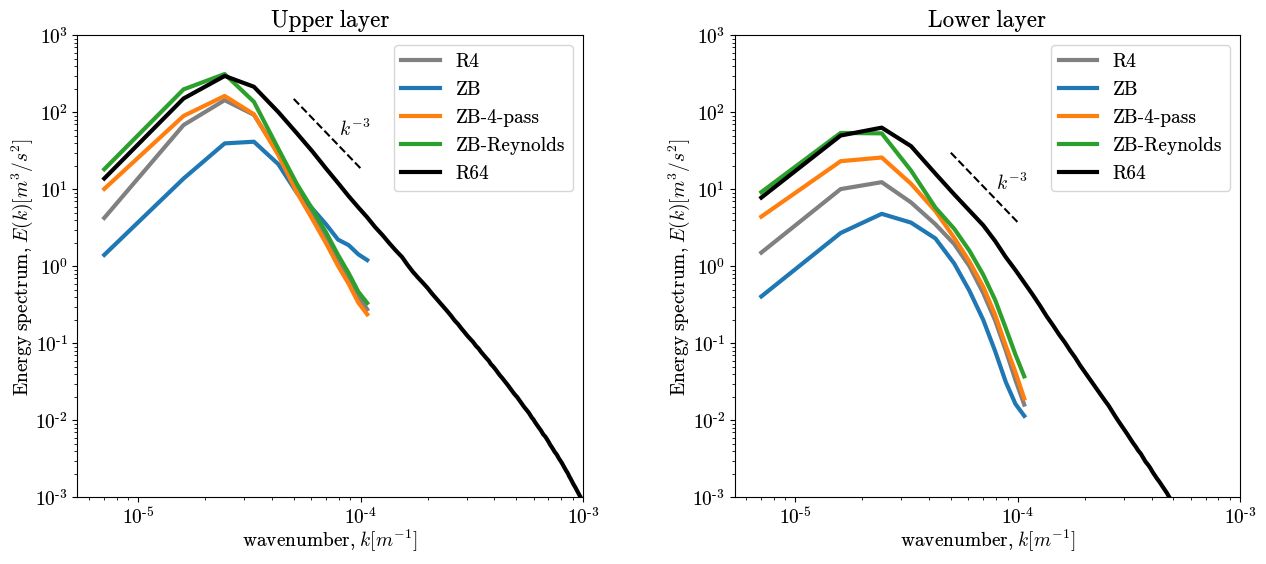

In [40]:
ds.plot_KE_spectrum(['ZB-clean-Cs-0.03-ZB-0.0', 'ZB-clean-Cs-0.03-ZB-0.3', 'ZB-stress-pass-4-sel-1-Cs-0.03-ZB-0.7','ZB-Reynolds-pass-4-pass-4-Cs-0.03-ZB-1.8', 'R64'], labels=['R4', 'ZB', 'ZB-4-pass', 'ZB-Reynolds', 'R64'])



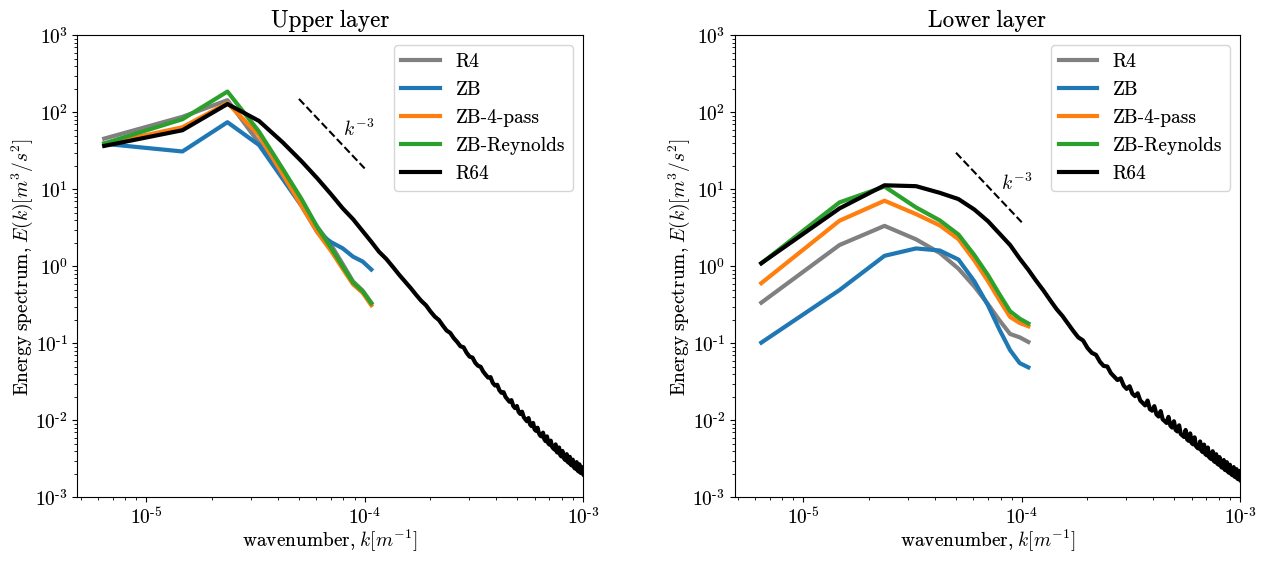

In [54]:
ds.plot_KE_spectrum(['ZB-clean-Cs-0.03-ZB-0.0', 'ZB-clean-Cs-0.03-ZB-0.3', 'ZB-stress-pass-4-sel-1-Cs-0.03-ZB-0.7','ZB-Reynolds-pass-4-pass-4-Cs-0.03-ZB-1.8', 'R64'], labels=['R4', 'ZB', 'ZB-4-pass', 'ZB-Reynolds', 'R64'], key='KE_spectrum_global')



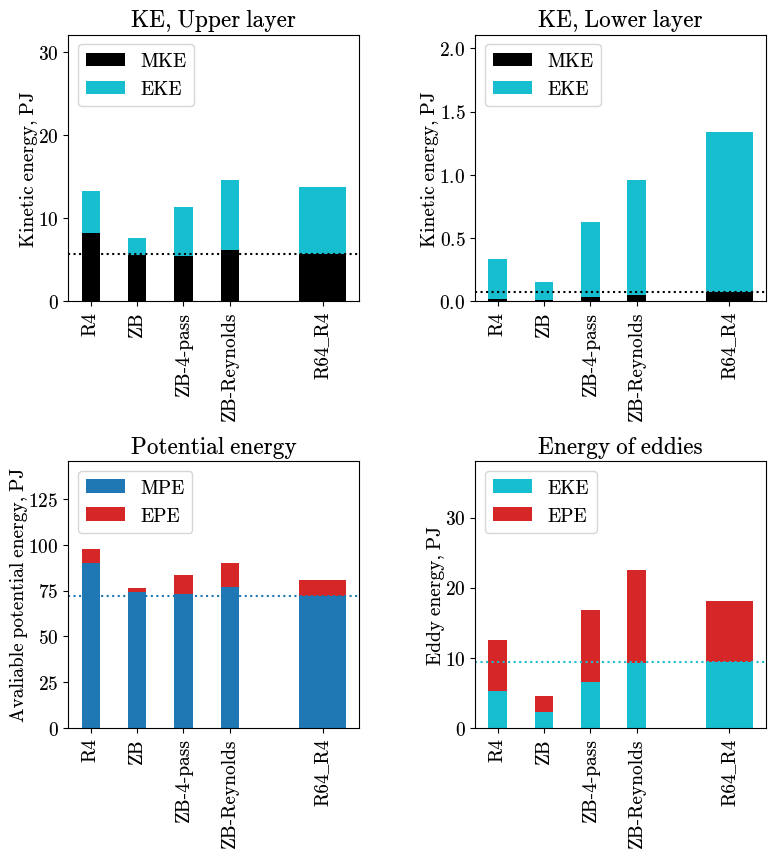

In [47]:
ds.plot_KE_PE(['ZB-clean-Cs-0.03-ZB-0.0', 'ZB-clean-Cs-0.03-ZB-0.3', 'ZB-stress-pass-4-sel-1-Cs-0.03-ZB-0.7','ZB-Reynolds-pass-4-pass-4-Cs-0.03-ZB-1.8', 'R64_R4'], labels=['R4', 'ZB', 'ZB-4-pass', 'ZB-Reynolds', 'R64_R4'])


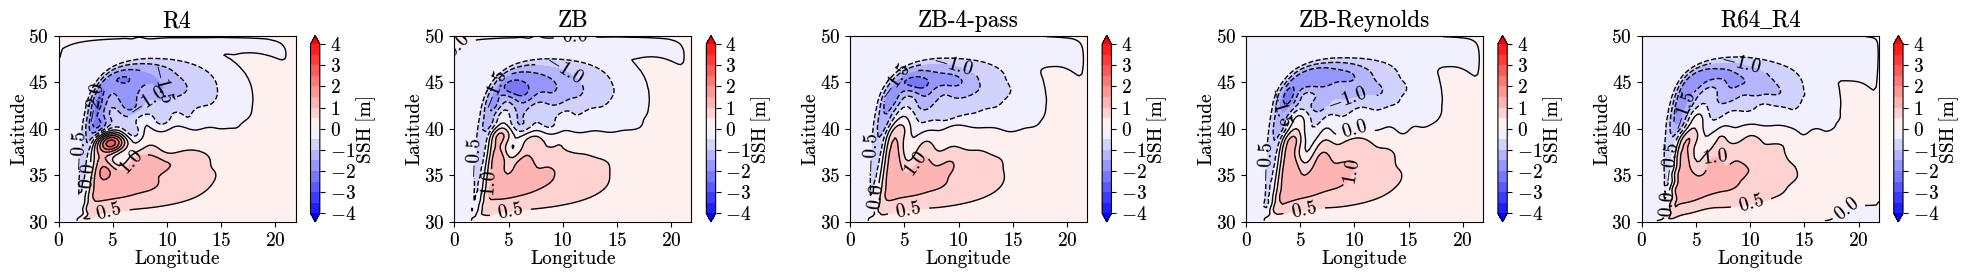

In [44]:
ds.plot_ssh(['ZB-clean-Cs-0.03-ZB-0.0', 'ZB-clean-Cs-0.03-ZB-0.3', 'ZB-stress-pass-4-sel-1-Cs-0.03-ZB-0.7','ZB-Reynolds-pass-4-pass-4-Cs-0.03-ZB-1.8', 'R64_R4'], labels=['R4', 'ZB', 'ZB-4-pass', 'ZB-Reynolds', 'R64_R4'])


# Cs 0.06

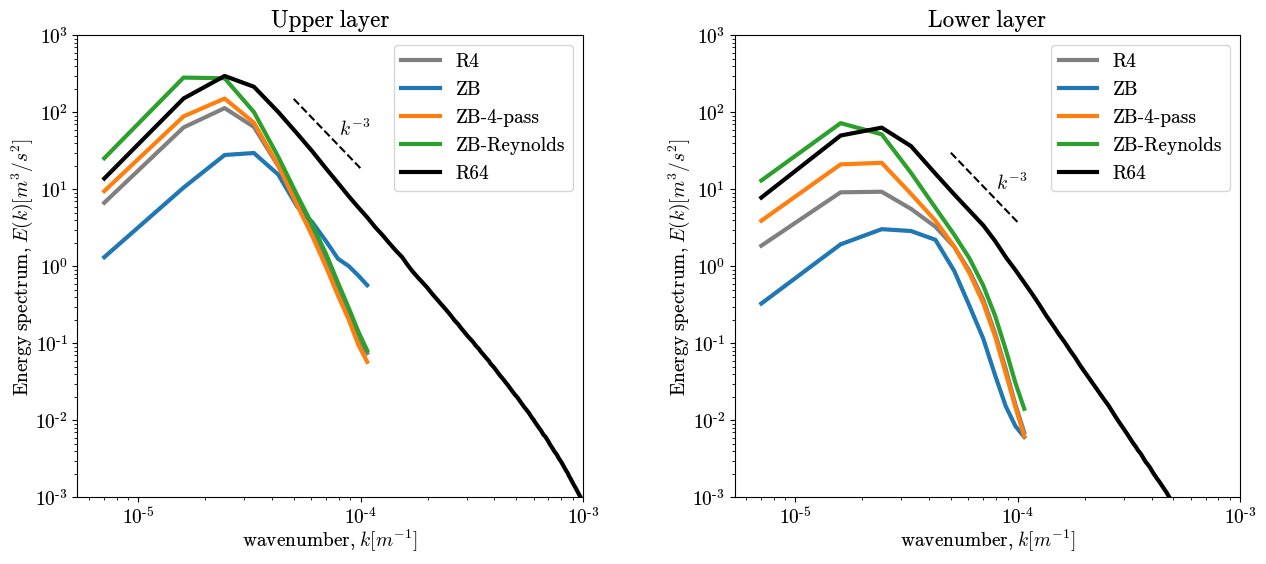

In [25]:
ds.plot_KE_spectrum(['R4', 'ZB-clean-Cs-0.06-ZB-0.5', 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-0.9','ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-2.8', 'R64'], labels=['R4', 'ZB', 'ZB-4-pass', 'ZB-Reynolds', 'R64'])



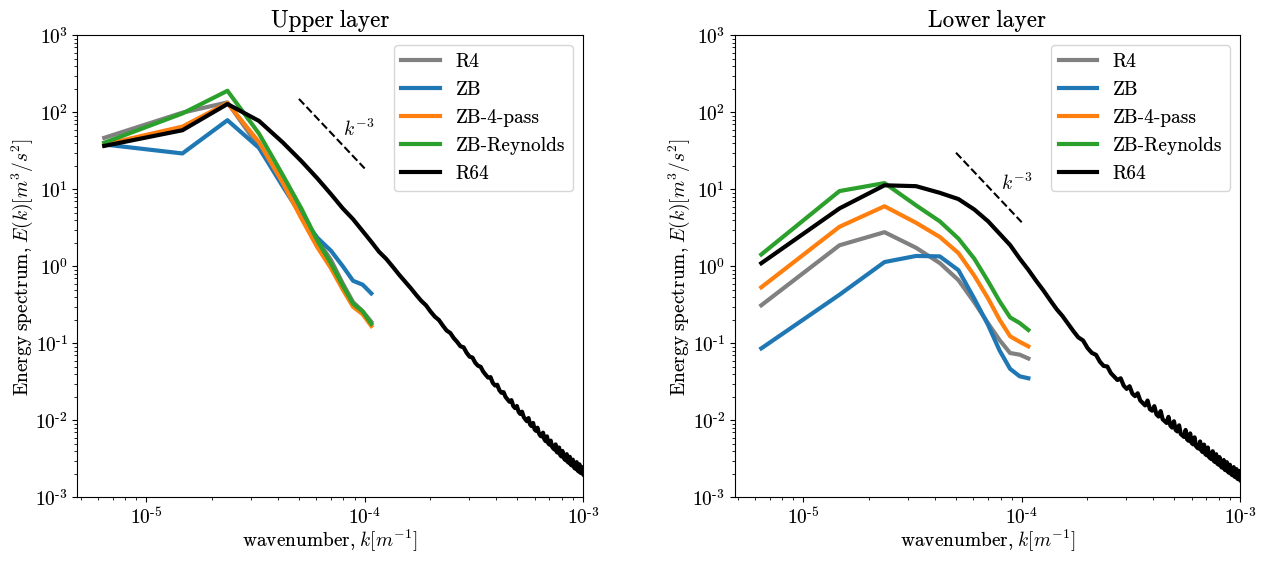

In [53]:
ds.plot_KE_spectrum(['R4', 'ZB-clean-Cs-0.06-ZB-0.5', 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-0.9','ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-2.8', 'R64'], labels=['R4', 'ZB', 'ZB-4-pass', 'ZB-Reynolds', 'R64'], key='KE_spectrum_global')



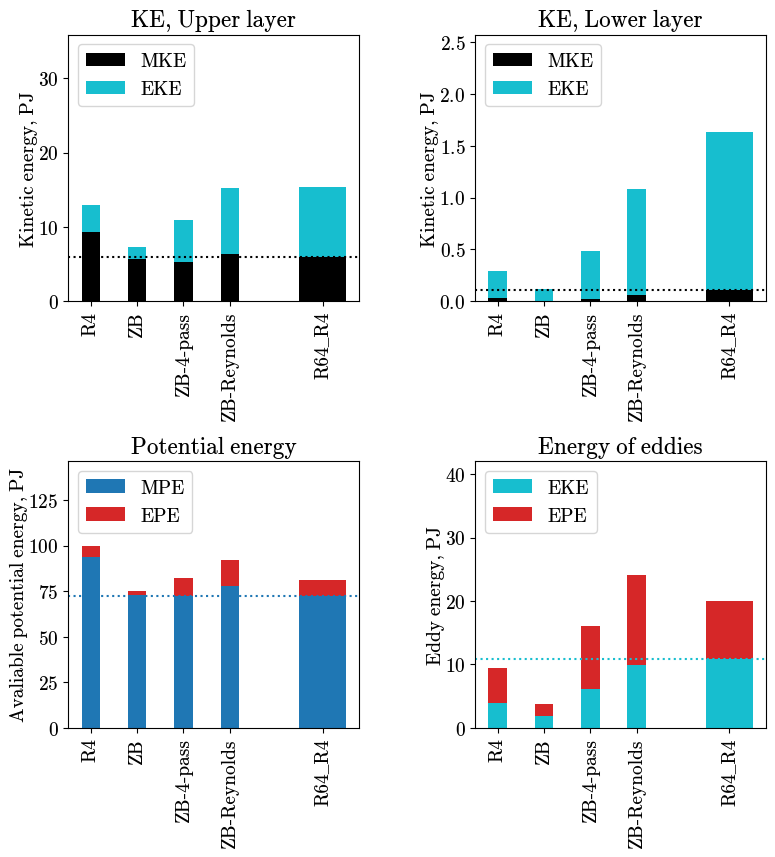

In [48]:
ds.plot_KE_PE(['R4', 'ZB-clean-Cs-0.06-ZB-0.5', 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-0.9','ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-2.8', 'R64'], labels=['R4', 'ZB', 'ZB-4-pass', 'ZB-Reynolds', 'R64_R4'])



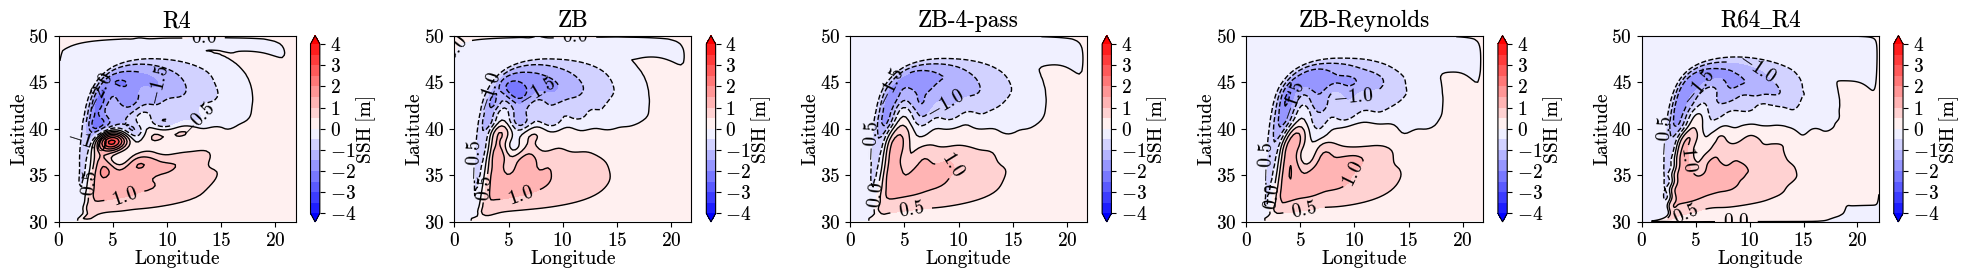

In [27]:
ds.plot_ssh(['R4', 'ZB-clean-Cs-0.06-ZB-0.5', 'ZB-stress-pass-4-sel-1-Cs-0.06-ZB-0.9','ZB-Reynolds-pass-4-pass-4-Cs-0.06-ZB-2.8', 'R64'], labels=['R4', 'ZB', 'ZB-4-pass', 'ZB-Reynolds', 'R64_R4'])



# Cs 0.09

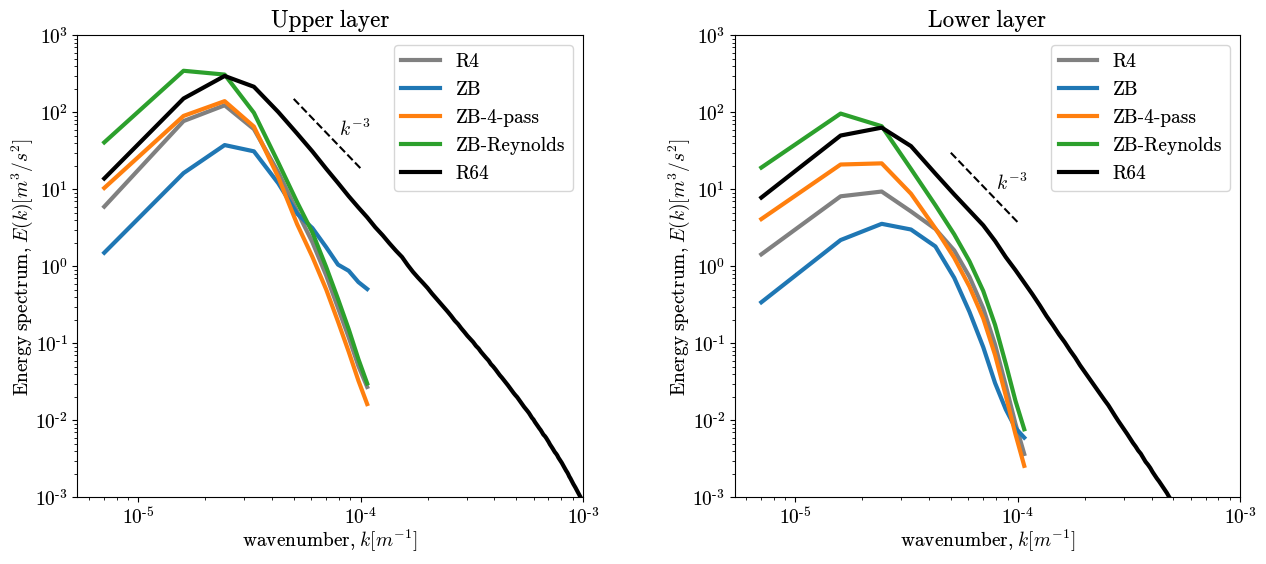

In [45]:
ds.plot_KE_spectrum(['ZB-clean-Cs-0.09-ZB-0.0', 'ZB-clean-Cs-0.09-ZB-0.7', 'ZB-stress-pass-4-sel-1-Cs-0.09-ZB-1.4','ZB-Reynolds-pass-4-pass-4-Cs-0.09-ZB-4.2', 'R64'], labels=['R4', 'ZB', 'ZB-4-pass', 'ZB-Reynolds', 'R64'])



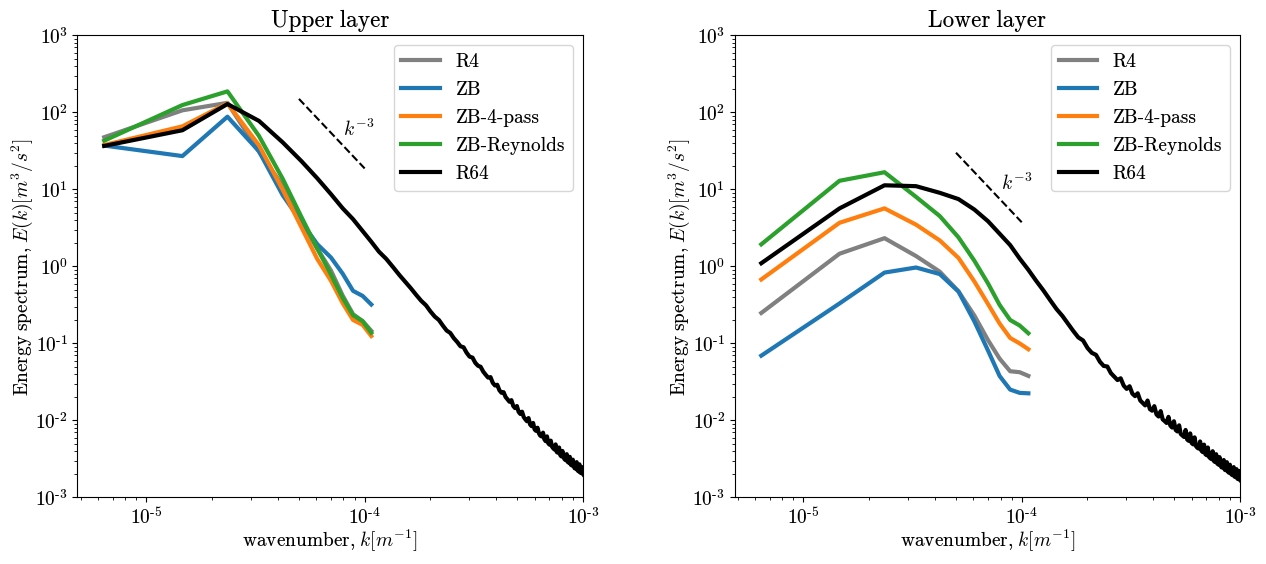

In [52]:
ds.plot_KE_spectrum(['ZB-clean-Cs-0.09-ZB-0.0', 'ZB-clean-Cs-0.09-ZB-0.7', 'ZB-stress-pass-4-sel-1-Cs-0.09-ZB-1.4','ZB-Reynolds-pass-4-pass-4-Cs-0.09-ZB-4.2', 'R64'], labels=['R4', 'ZB', 'ZB-4-pass', 'ZB-Reynolds', 'R64'], key='KE_spectrum_global')



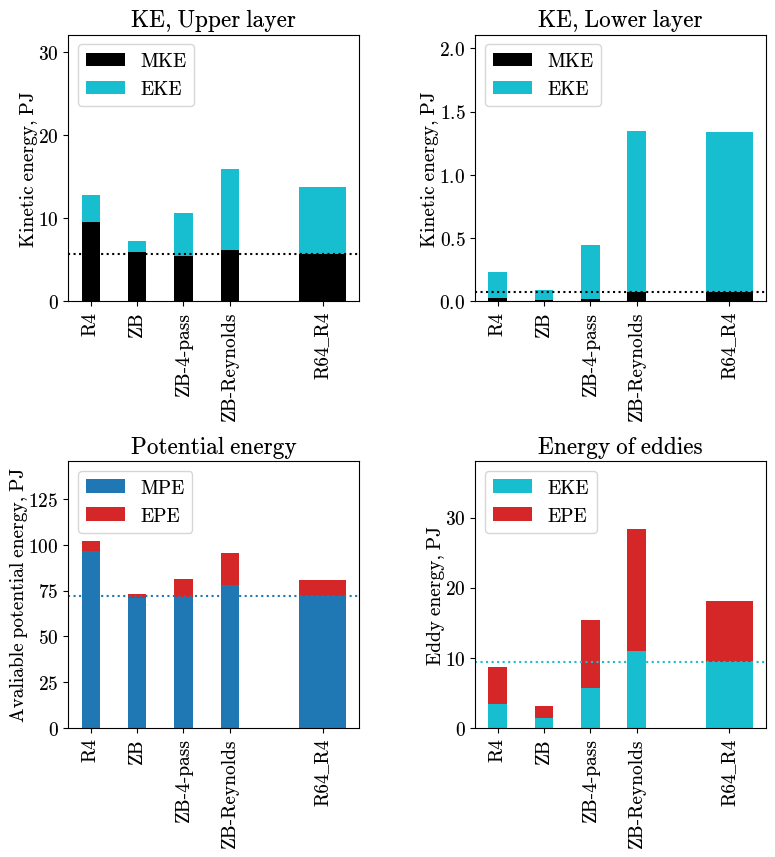

In [49]:
ds.plot_KE_PE(['ZB-clean-Cs-0.09-ZB-0.0', 'ZB-clean-Cs-0.09-ZB-0.7', 'ZB-stress-pass-4-sel-1-Cs-0.09-ZB-1.4','ZB-Reynolds-pass-4-pass-4-Cs-0.09-ZB-4.2', 'R64_R4'], labels=['R4', 'ZB', 'ZB-4-pass', 'ZB-Reynolds', 'R64_R4'])



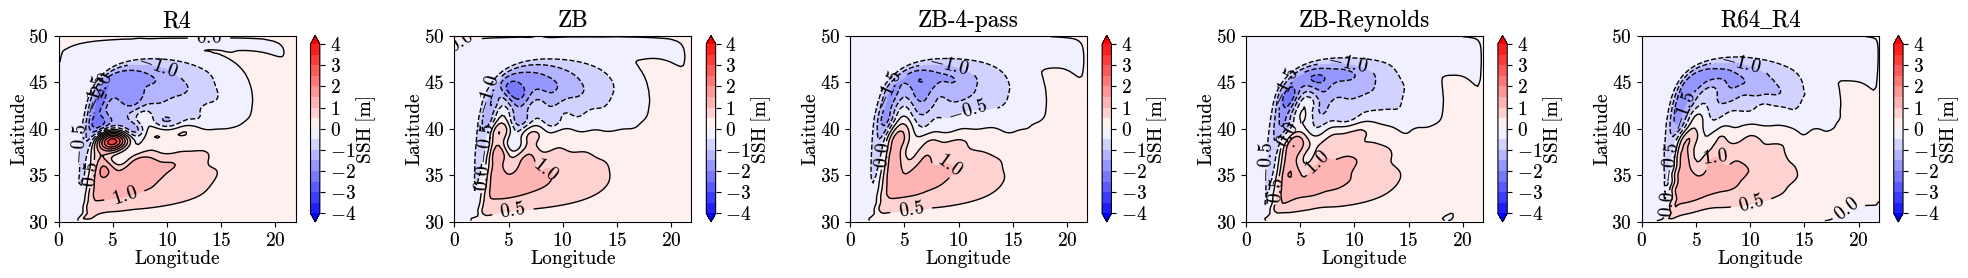

In [50]:
ds.plot_ssh(['ZB-clean-Cs-0.09-ZB-0.0', 'ZB-clean-Cs-0.09-ZB-0.7', 'ZB-stress-pass-4-sel-1-Cs-0.09-ZB-1.4','ZB-Reynolds-pass-4-pass-4-Cs-0.09-ZB-4.2', 'R64_R4'], labels=['R4', 'ZB', 'ZB-4-pass', 'ZB-Reynolds', 'R64_R4'])

